In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
%load_ext autoreload
%autoreload 2

In [10]:
import torch
import pickle
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import procrustes
import matplotlib.pyplot as plt

from lrm_steering.lrm_models.feature_extractor import *
from reprGeo_default.scripts.data_utils import *
from reprGeo_default.scripts.metrics import *
from reprGeo_default.scripts.viz import *

numCate = 60
imagesPerCate = 100
DEFAULT_COLORS = {'base':'#5B0A0B','mod':'#E41A1C','vanilla':'#7f7f7f'}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

idx2label, idx2number, number2label = load_imagenet_label_maps('/teamspace/studios/this_studio/imagenet_class_index.json')

In [4]:
activations_1 = torch.load(f'reprGeo_output/activations_pass1_imagenettrain_100*300.pt')
# activations_2 = torch.load(f'reprGeo_output/activations_pass2_imagenettrain_{numCate}*{imagesPerCate}.pt')
activations_3 = torch.load(f'reprGeo_output/activations_pass3_imagenettrain_100*300.pt')
labels_1 = torch.load(f'reprGeo_output/labels_pass1_imagenettrain_100*300.pt')
# with open(f'reprGeo_output/categories_{numCate}*{imagesPerCate}.pkl', 'rb') as f:
#     categories_1 = pickle.load(f)

# Load Model & Data Loader

In [4]:
# this will fetch the list of all model‐factory functions in cindyluo99/lrm-steering (dev branch)
models = torch.hub.list('cindyluo99/lrm-steering', 'dev')
print(models)

Downloading: "https://github.com/cindyluo99/lrm-steering/zipball/main" to /home/zeus/.cache/torch/hub/main.zip


['LRMNet', 'SteerableLRM', 'alexnet_lrm1', 'alexnet_lrm2', 'alexnet_lrm3', 'get_standard_transforms']


In [ ]:
# path to dataset
dataset_path = f'/teamspace/studios/this_studio/imageData/{numCate}*{imagesPerCate}_imageNet_train_random'

# Load the pre-trained alexnet_lrm3 model (without steering)
model, transforms = torch.hub.load('cindyluo99/lrm-steering:dev', 'alexnet_lrm3', pretrained=True, steering=False, force_reload=True)
val_transform = transforms['val_transform'] # should i change it to train?

val_dataloader = create_dataLoader(dataset_path, val_transform, idx2number, 100, 4)
model.to(device)

# Multiple Layers

In [ ]:
print("\n".join(get_layer_names(model)))

In [ ]:
# bebugging
# pick a single minibatch
images, labels = next(iter(val_dataloader))
images = images.to(device)

# pick a handful of layer names to test
# pre-relu
layers_to_extract = [
    "feedforward.features.0",   # Conv1
    "feedforward.features.3",   # Conv2
    "feedforward.features.6",   # Conv3
    "feedforward.features.8",   # Conv4
    "feedforward.features.10",  # Conv5
    "feedforward.classifier.1", # FC6
    "feedforward.classifier.6"  # Output
]

# swap in a temporary extractor that logs shape
temp_extractor = FeatureExtractor(model, layers_to_test, device=device)
with temp_extractor as ex:
    _ = model(images, drop_state=True, forward_passes=3)

for layer in layers_to_test:
    feats = temp_extractor._features[layer]      # this is a list of length == forward_passes
    print(f"{layer:30s} →  num passes: {len(feats)}")
    for pass_idx, tensor in enumerate(feats):
        print(f"    pass {pass_idx:>2d}: shape = {tuple(tensor.shape)}")
    print("    sample values:", feats[-1].view(-1)[:5].cpu().numpy(), "…\n")

## Obtain Activations

In [ ]:
# 2. Which layers you want:
# pre-relu
# layers_to_extract = [
#     "feedforward.features.0",    # Conv1
#     'feedforward.features.6',    # Conv3
#     "feedforward.features.10",   # Conv5
#     "feedforward.classifier.1",  # FC6 (second-to-last)
#     "feedforward.classifier.6"   # Output (second-to-last)
# ]

# post-relu
layers_to_extract = [
    "feedforward.features.1",   # post‐ReLU1, before Pool1
    "feedforward.features.4",   # post‐ReLU2, before Pool2
    "feedforward.features.7",   # post‐ReLU3
    "feedforward.features.9",   # post‐ReLU4
    "feedforward.features.11",  # post‐ReLU5
    "feedforward.classifier.1", # FC6
    "feedforward.classifier.6"  # Output
]

out_dir = "reprGeo_output"
os.makedirs(out_dir, exist_ok=True)

for layer_name in layers_to_extract:
    extractor = FeatureExtractor(model, layer_name, device=device)
    model.to(device)
    model.eval()

    for pass_num in [1, 3]:
        fname = f"activations_{layer_name.replace('.', '_')}_pass{pass_num}_{numCate}x{imagesPerCate}.pt"
        out_path = os.path.join(out_dir, fname)

        if os.path.exists(out_path):
            print(f"→ already saved, skipping: {fname}")
            continue
        
        # run your get_activation, but with get_accuracy=False if you like
        acts, cats, labels, acc = get_activation(
            model,
            val_dataloader,
            layer_name,
            extractor,
            number2label,
            device,
            forward_passes=pass_num,
            drop_state=True,
            get_accuracy=False
        )

        # if conv‐layer, flatten to [N, C*H*W]
        # flatten for now, but still interesting to:
        # 	1.	examine those C different sim-matrices one by one, or
	    #   2.	average them / look at their variance / cluster them, etc. 
        # why: might be relevant to amplification & suppression
        if acts.dim() == 4:
            N, C, H, W = acts.shape
            acts = acts.view(N, -1)  # flatten

        # save
        fname = f"activations_{layer_name.replace('.', '_')}_pass{pass_num}_{numCate}x{imagesPerCate}.pt"
        torch.save(acts.cpu(), os.path.join(out_dir, fname))
        print(f"→ saved {fname} ({tuple(acts.shape)})")

In [6]:
torch.save(labels, f'reprGeo_output/labels_multilayers_imagenettrain_{numCate}*{imagesPerCate}.pt')

## Run Representation Analysis





=== PROCESSING LAYER: feedforward_classifier_1 ===


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_diff
No. Observations: 6000    Method:             REML         
No. Groups:       60      Scale:              0.0004       
Min. group size:  100     Log-Likelihood:     14573.0199   
Max. group size:  100     Converged:          Yes          
Mean group size:  100.0                                    
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    -0.005     0.001  -6.337  0.000  -0.006  -0.003
Group Var     0.000     0.000                               

One-tailed p-value: 1.1702435446290146e-10


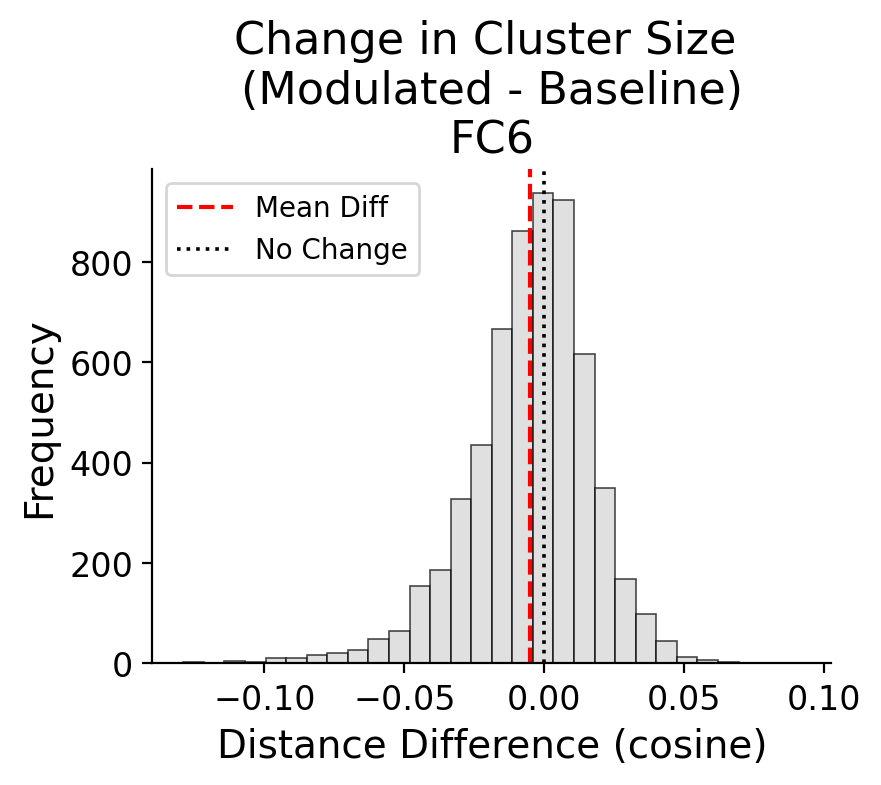

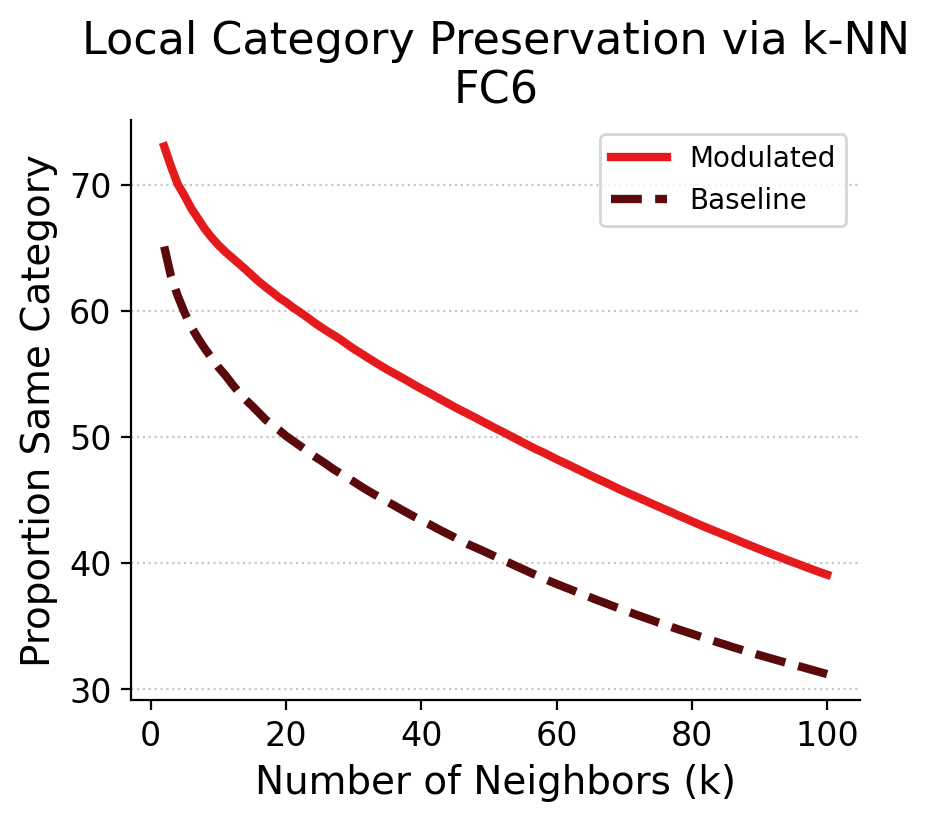

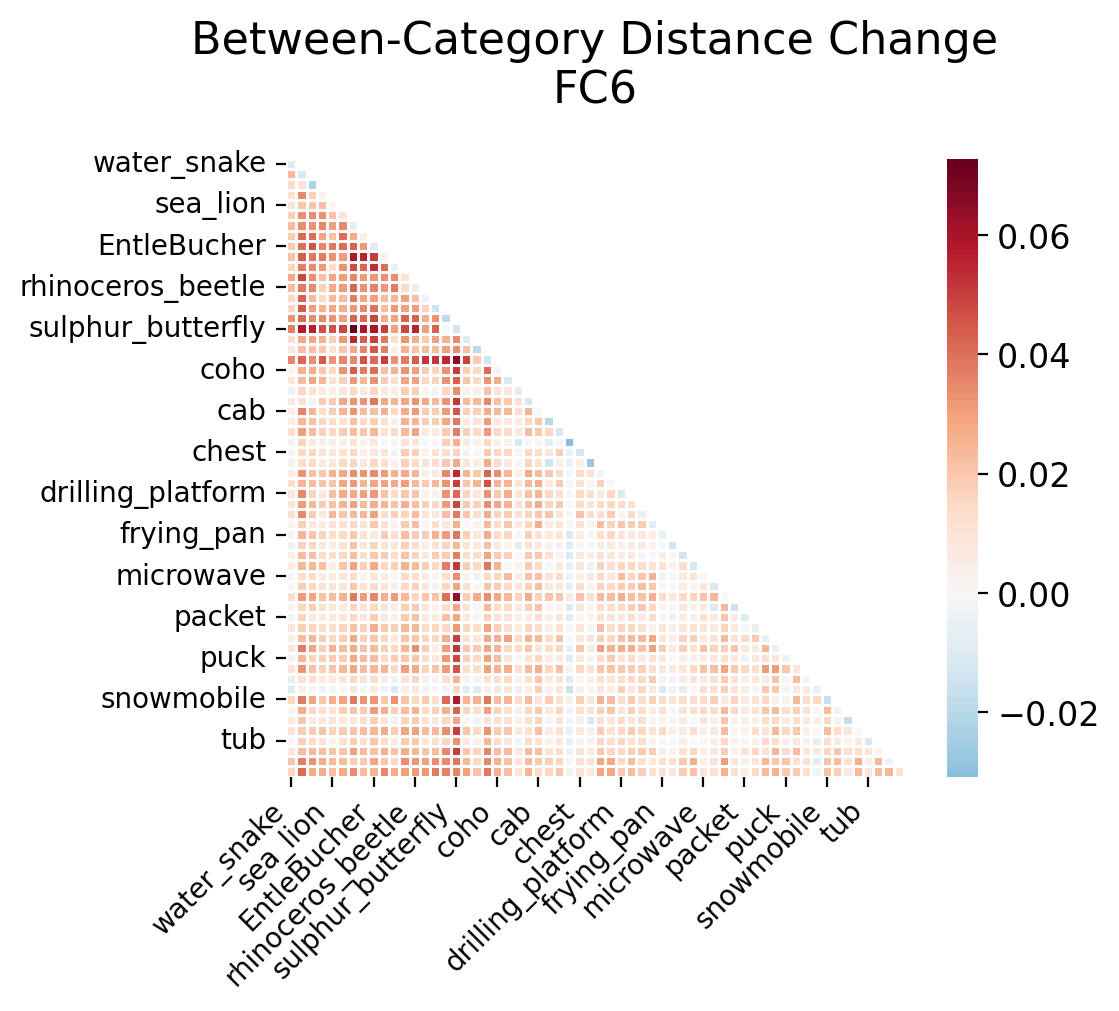

[feedforward_classifier_1]  avg shift=0.0050,  avg sep=0.2765,  Δsep=0.0307
[feedforward_classifier_1]  RSA ρ=0.985, p=0


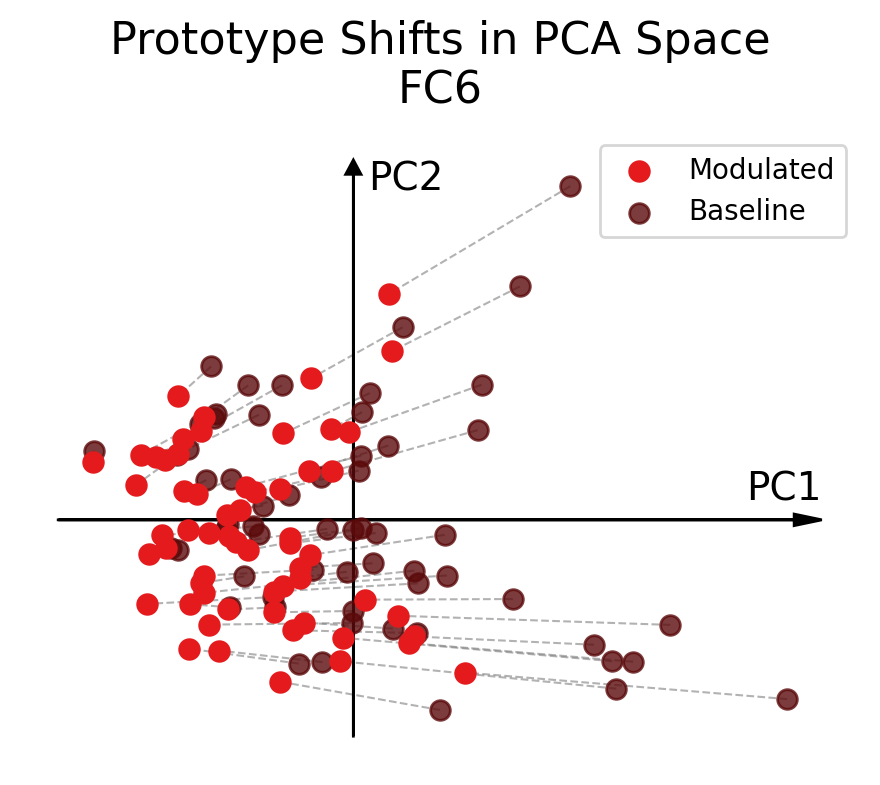

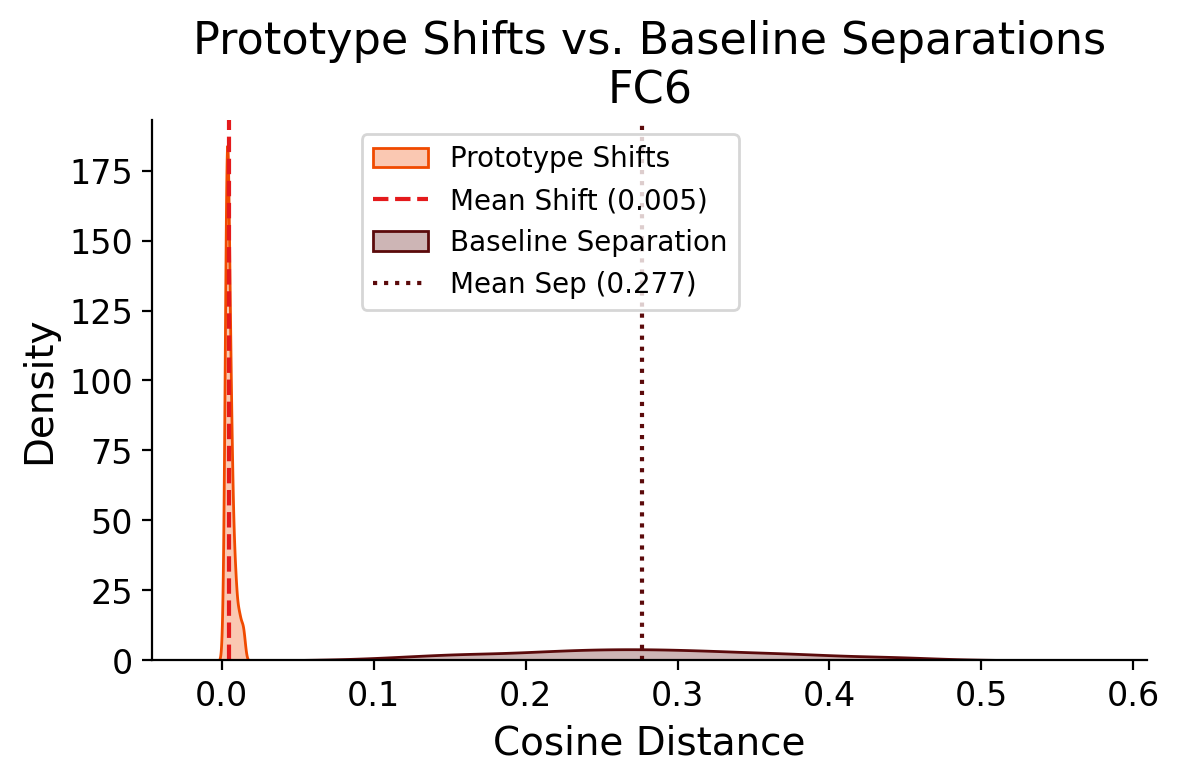

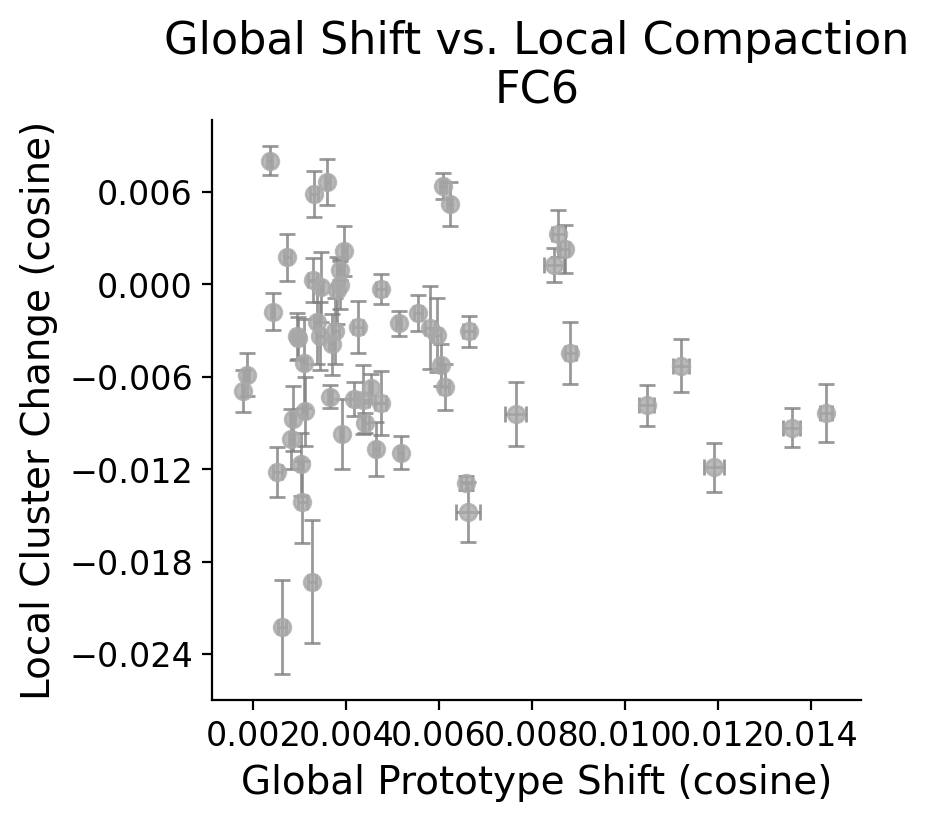





=== PROCESSING LAYER: feedforward_classifier_6 ===


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_diff
No. Observations: 6000    Method:             REML         
No. Groups:       60      Scale:              0.0016       
Min. group size:  100     Log-Likelihood:     10628.1513   
Max. group size:  100     Converged:          Yes          
Mean group size:  100.0                                    
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept   -0.034     0.002  -14.973  0.000  -0.038  -0.029
Group Var    0.000     0.001                                

One-tailed p-value: 5.508625637196251e-51


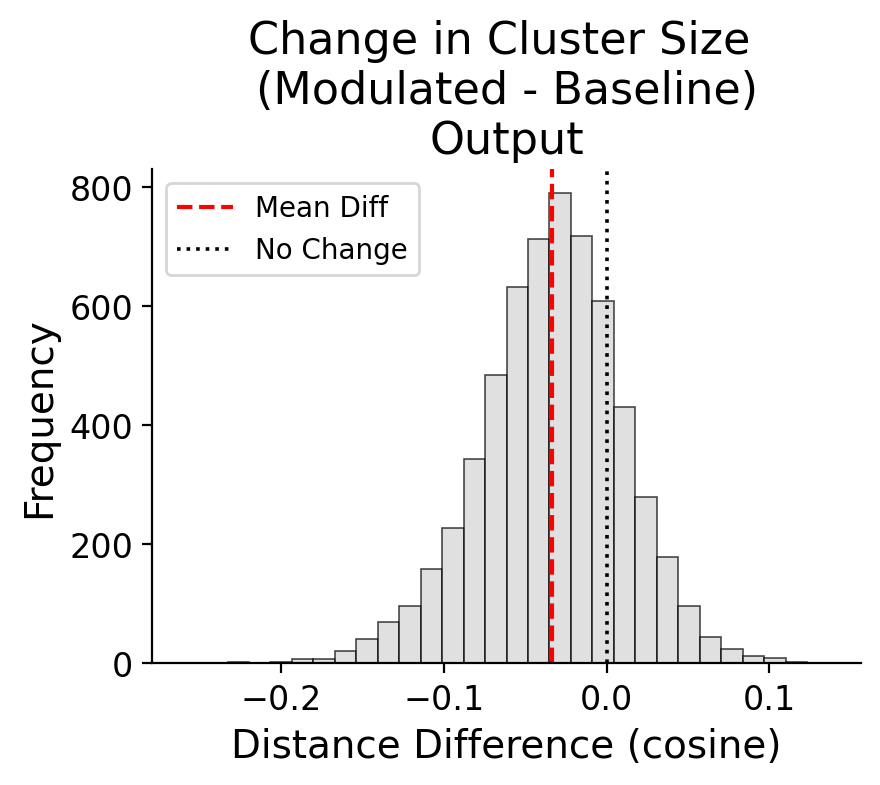

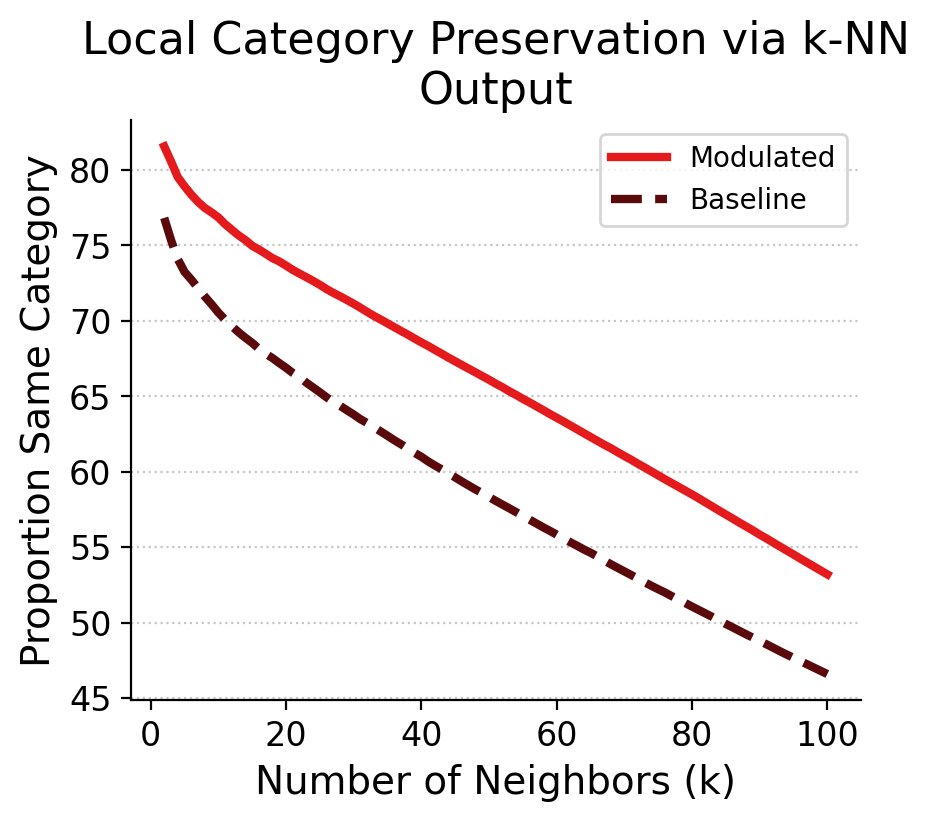

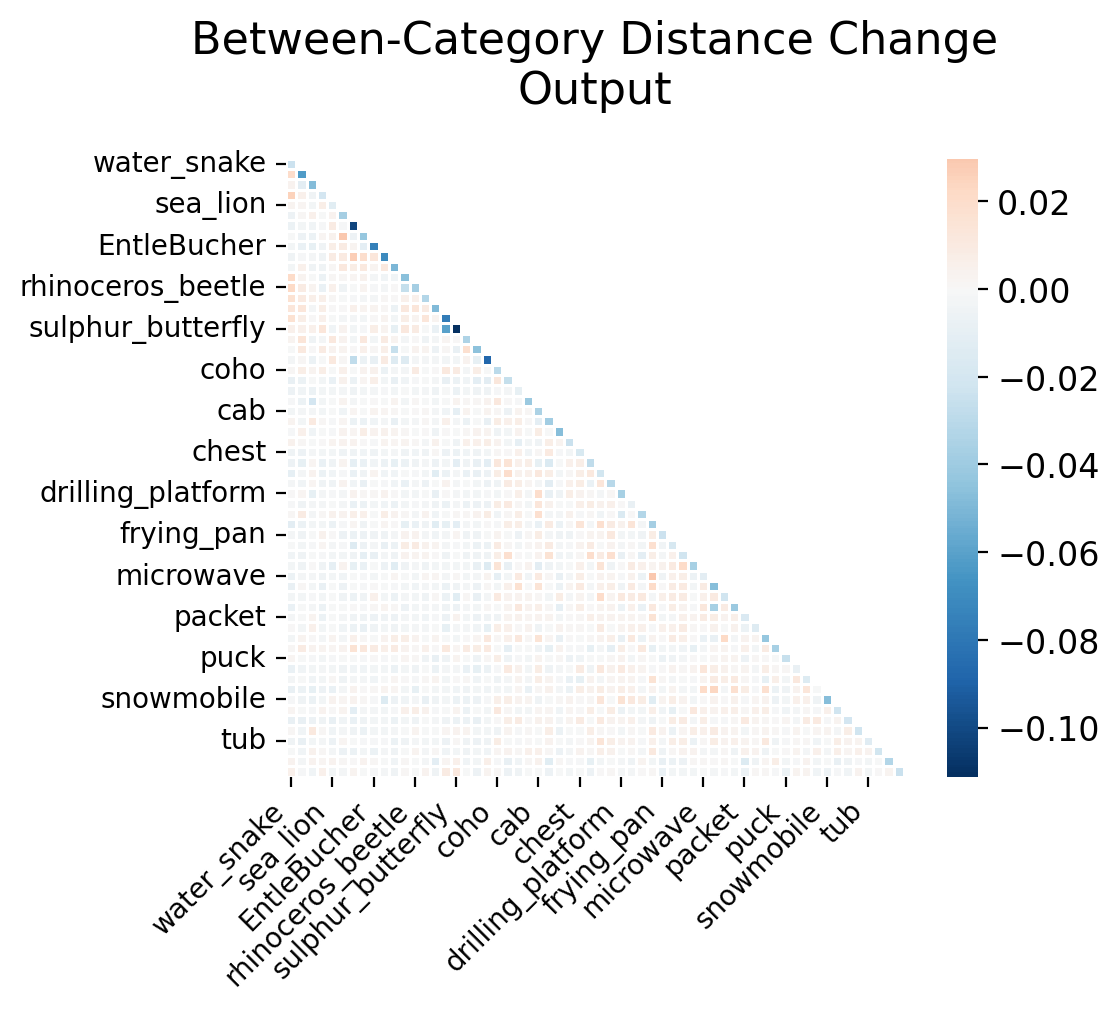

[feedforward_classifier_6]  avg shift=0.0135,  avg sep=0.9630,  Δsep=0.0030
[feedforward_classifier_6]  RSA ρ=0.959, p=0


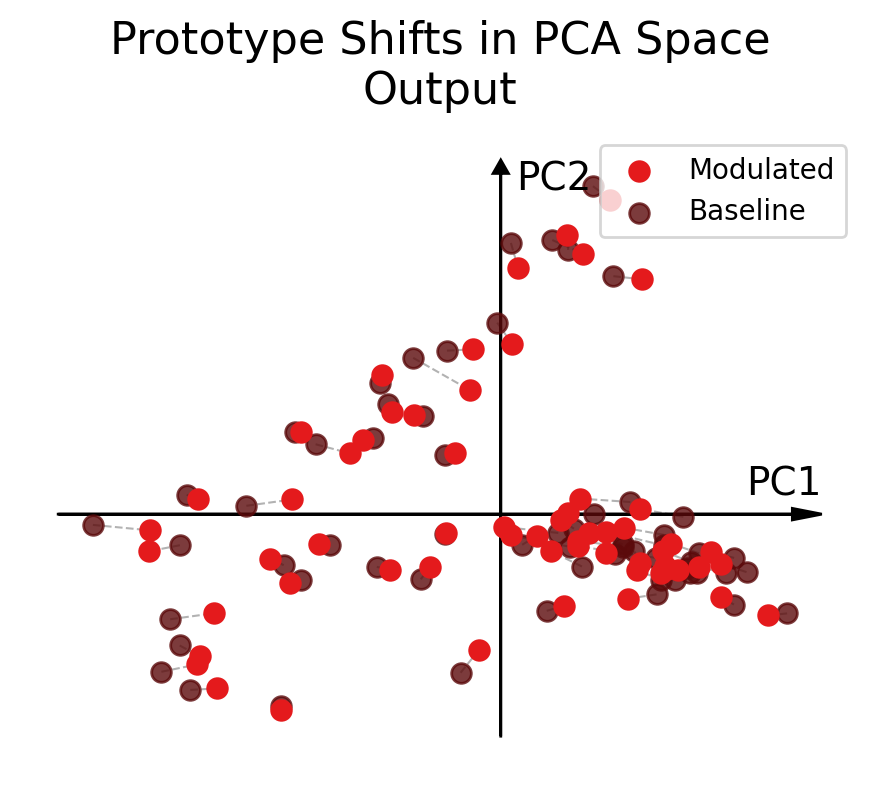

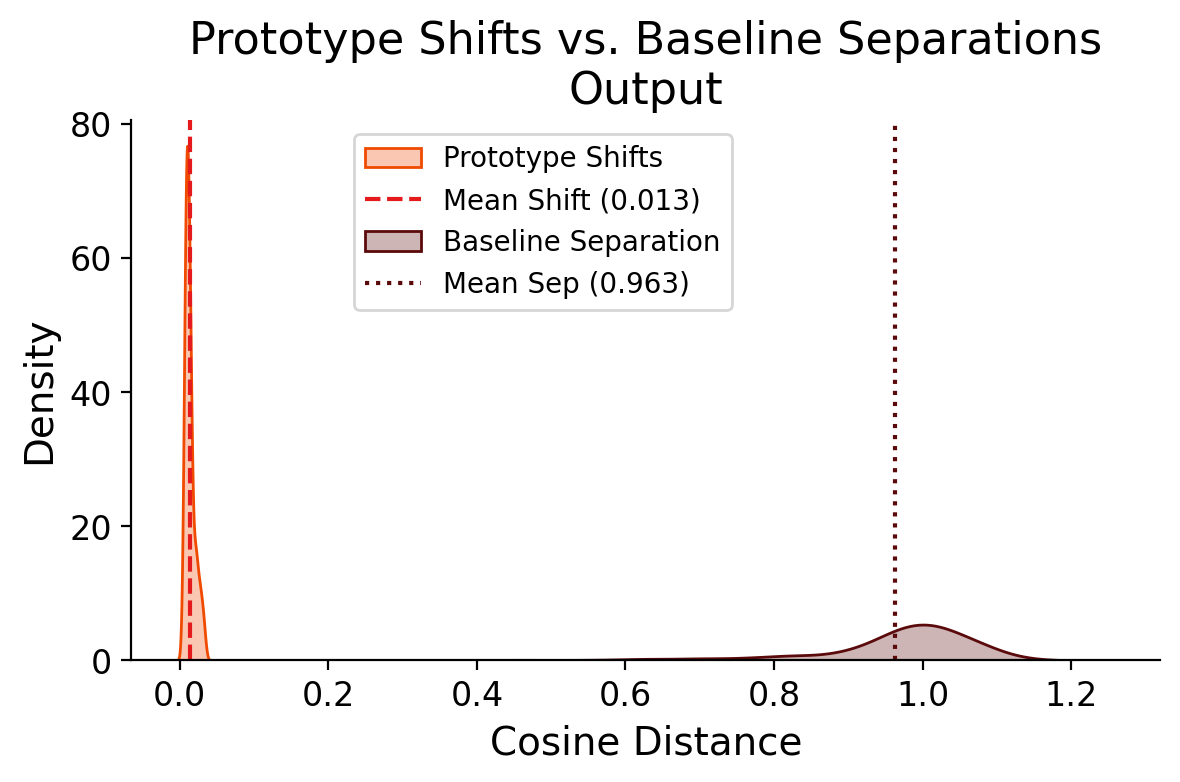

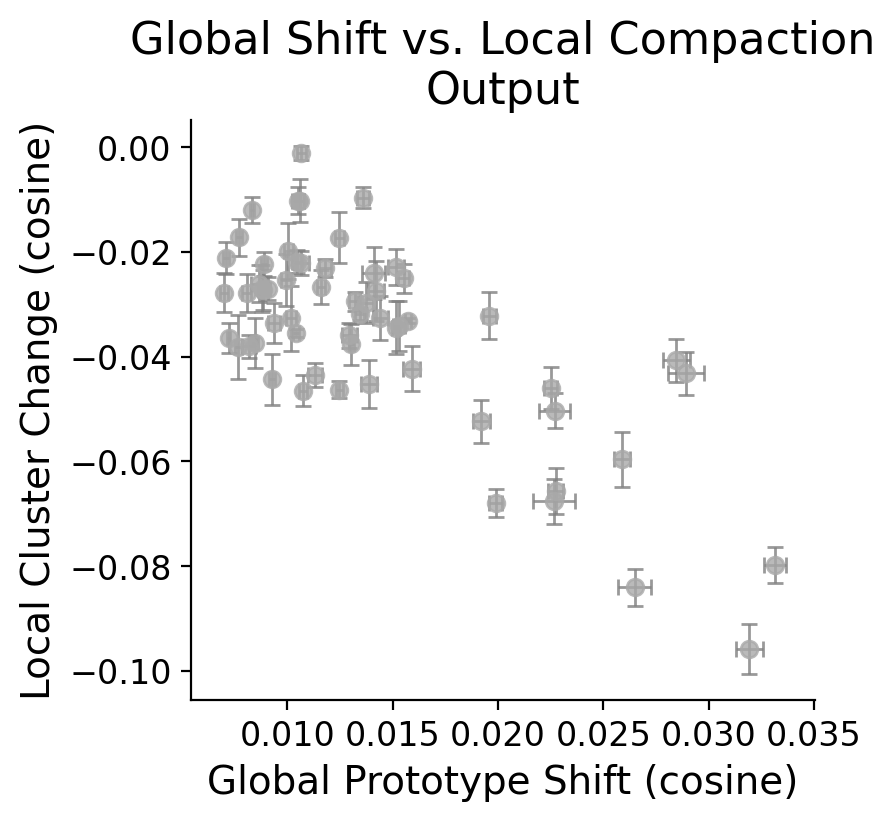





=== PROCESSING LAYER: feedforward_features_0 ===


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_diff
No. Observations: 6000    Method:             REML         
No. Groups:       60      Scale:              0.0067       
Min. group size:  100     Log-Likelihood:     6418.7396    
Max. group size:  100     Converged:          Yes          
Mean group size:  100.0                                    
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept   -0.047     0.004  -11.893  0.000  -0.055  -0.040
Group Var    0.001     0.002                                

One-tailed p-value: 6.399934680145753e-33


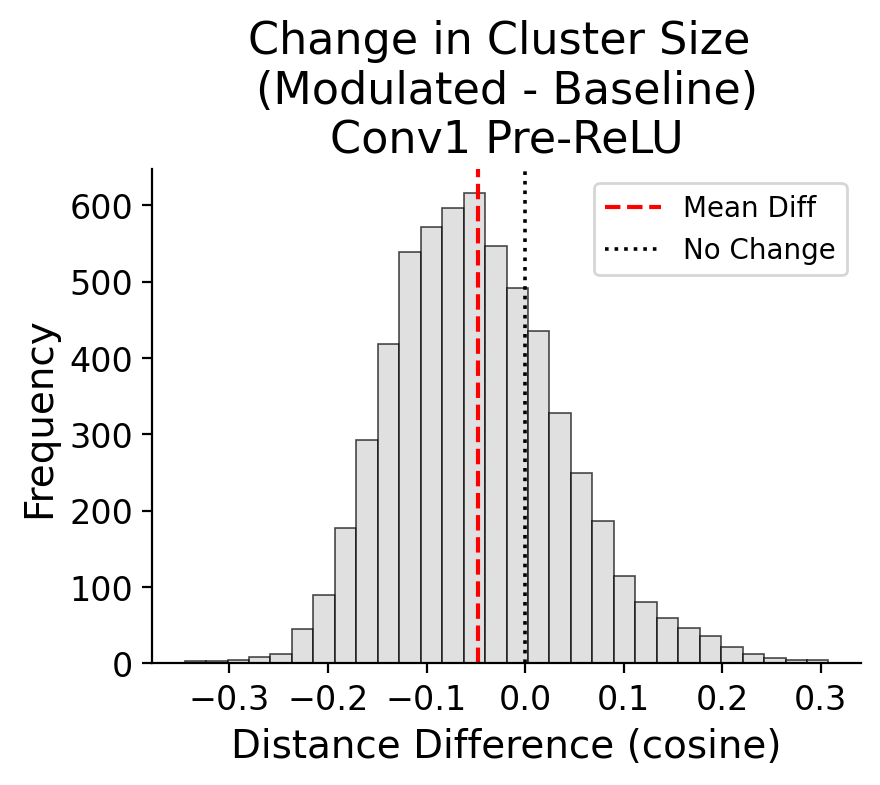

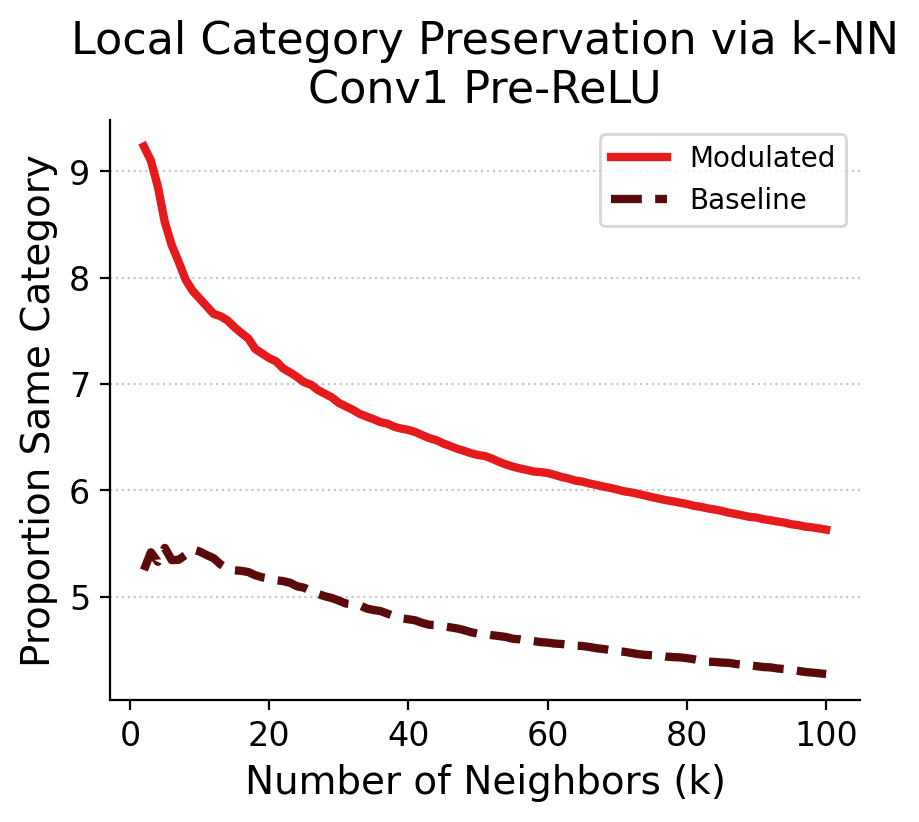

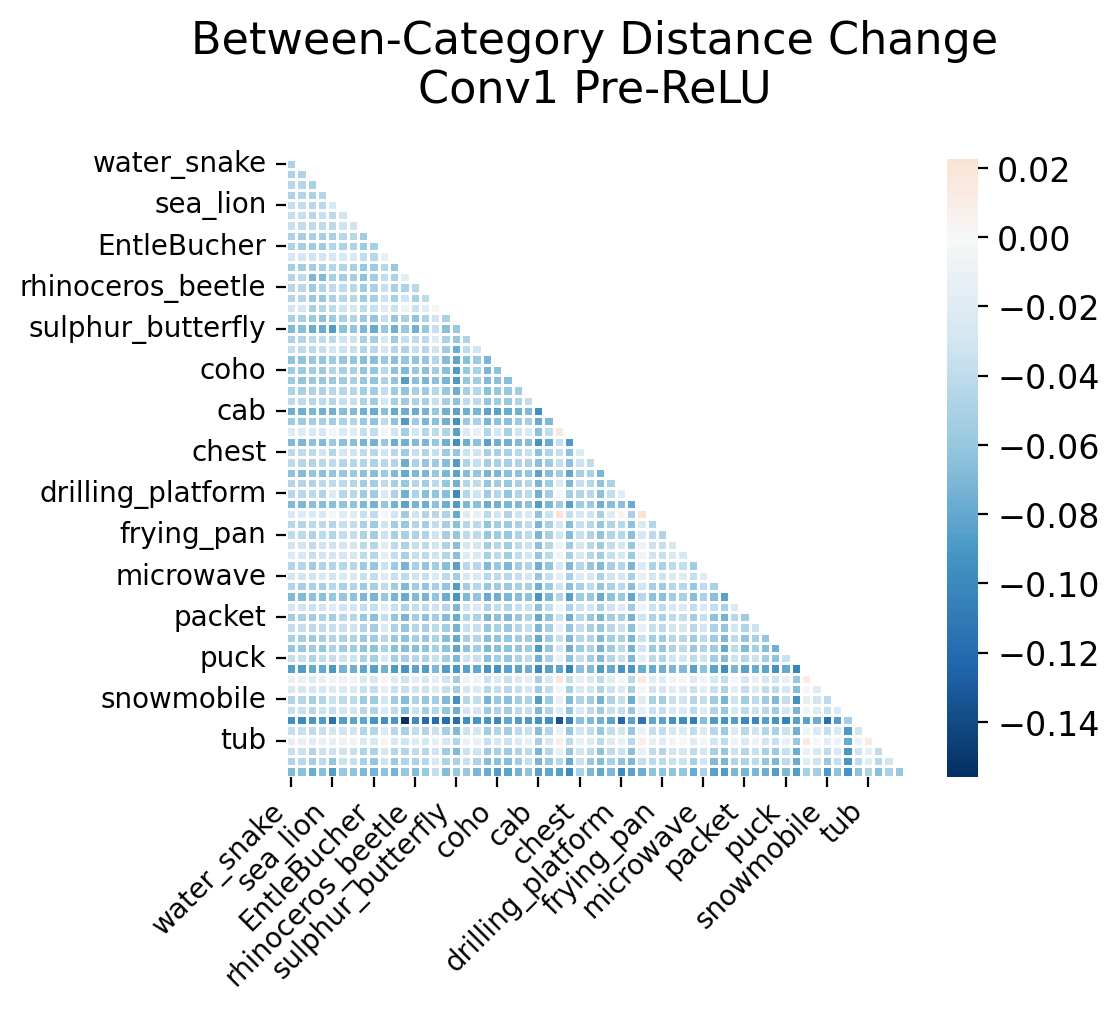

[feedforward_features_0]  avg shift=1.0212,  avg sep=0.1877,  Δsep=-0.0666
[feedforward_features_0]  RSA ρ=0.909, p=0


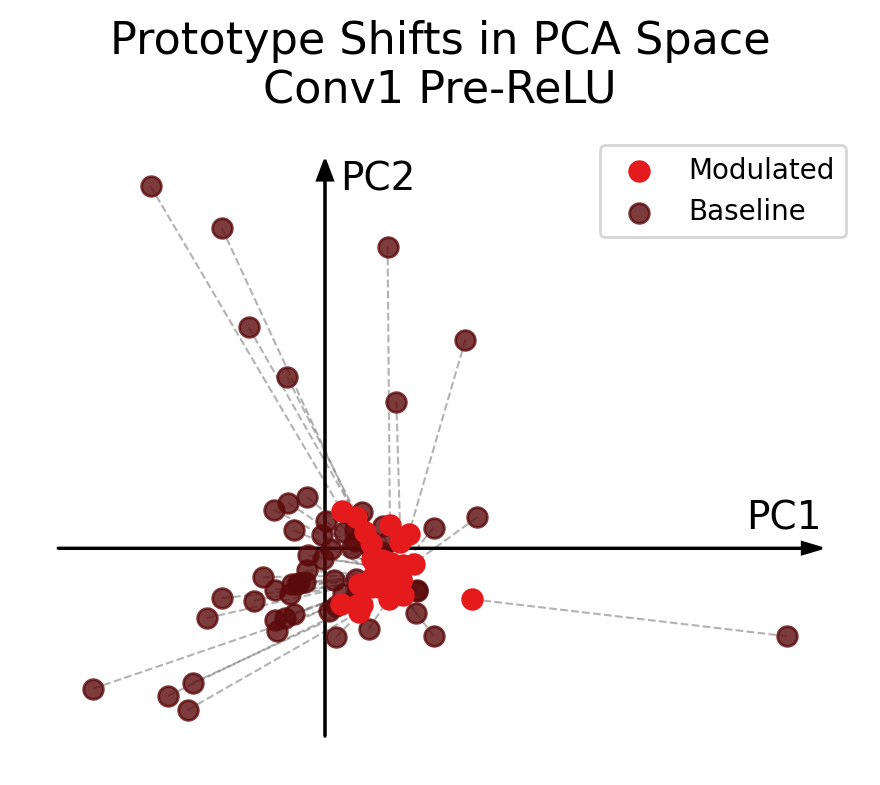

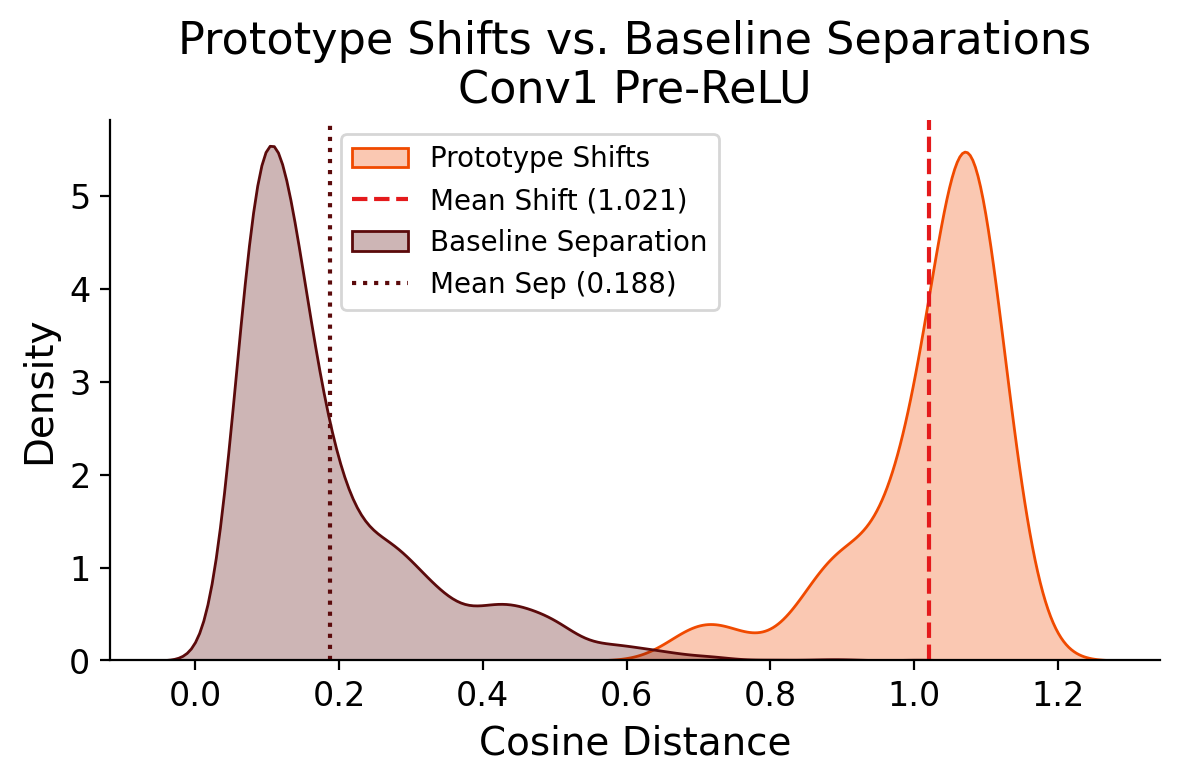

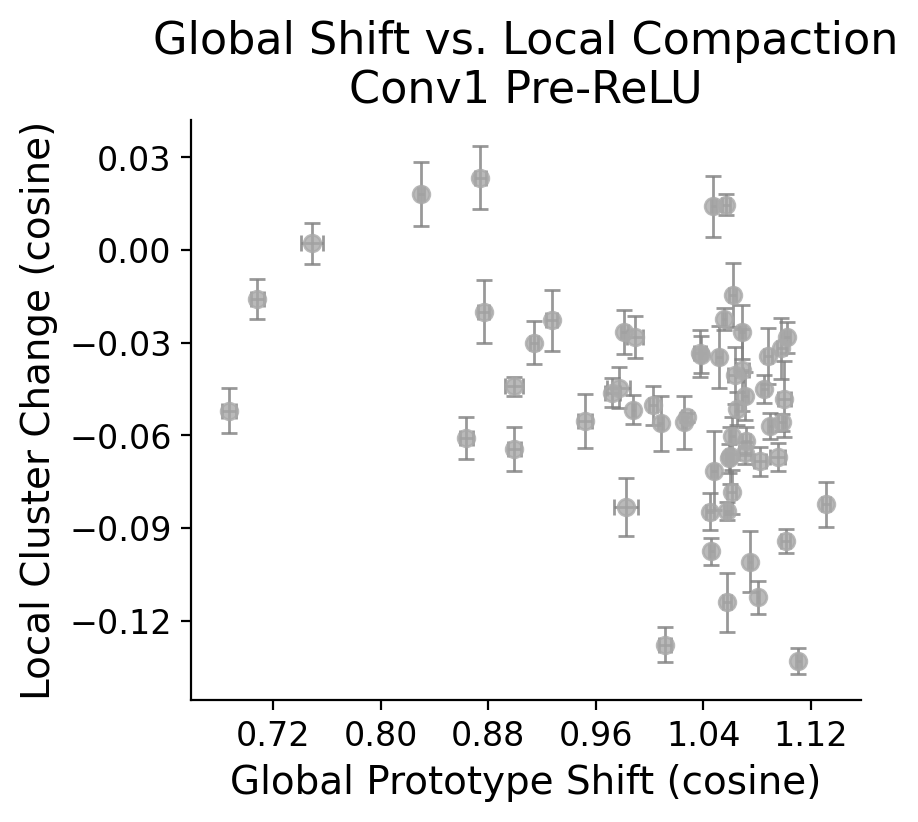





=== PROCESSING LAYER: feedforward_features_10 ===


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_diff
No. Observations: 6000    Method:             REML         
No. Groups:       60      Scale:              0.0042       
Min. group size:  100     Log-Likelihood:     7788.9974    
Max. group size:  100     Converged:          Yes          
Mean group size:  100.0                                    
------------------------------------------------------------
             Coef.  Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    0.416     0.004  100.854  0.000   0.408   0.424
Group Var    0.001     0.003                                

One-tailed p-value: 1.0


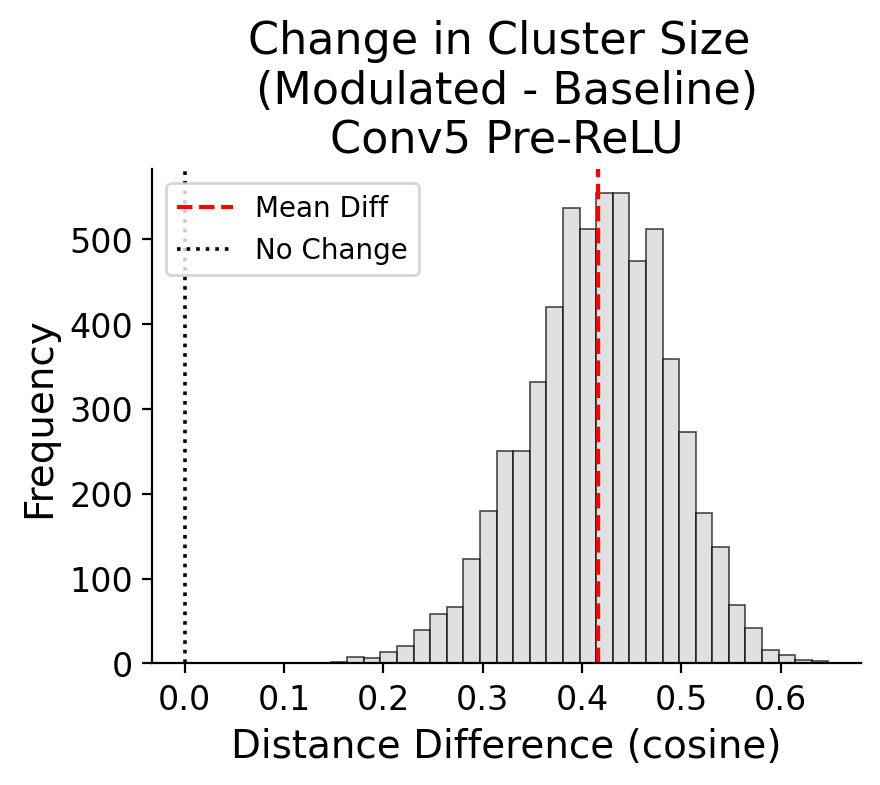

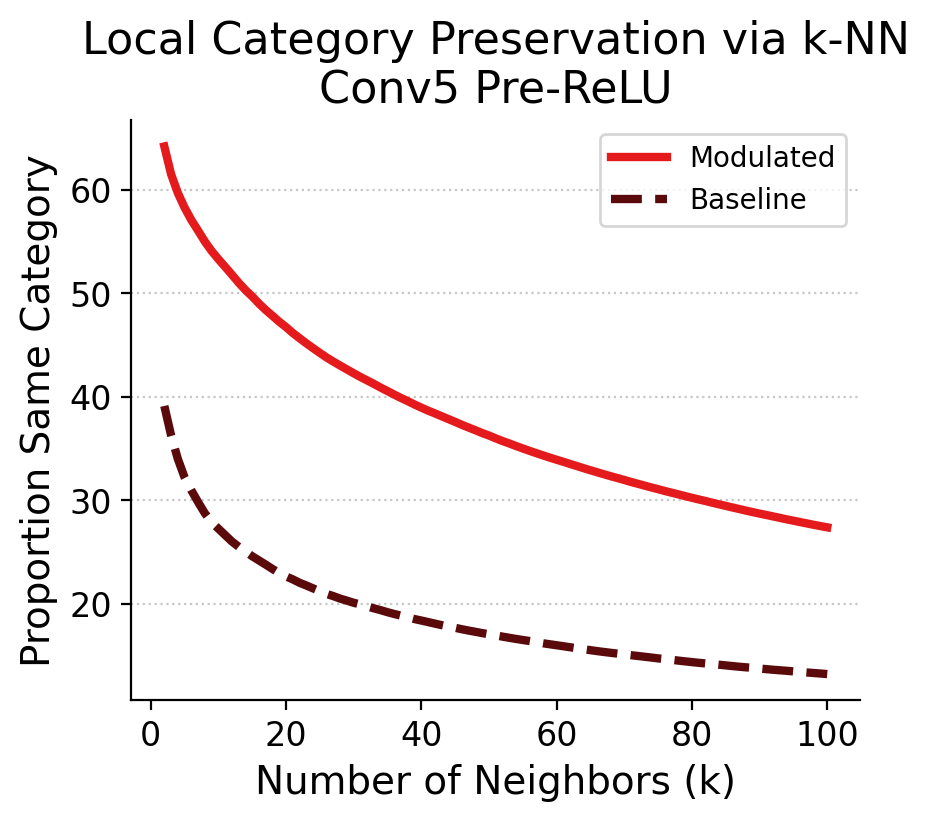

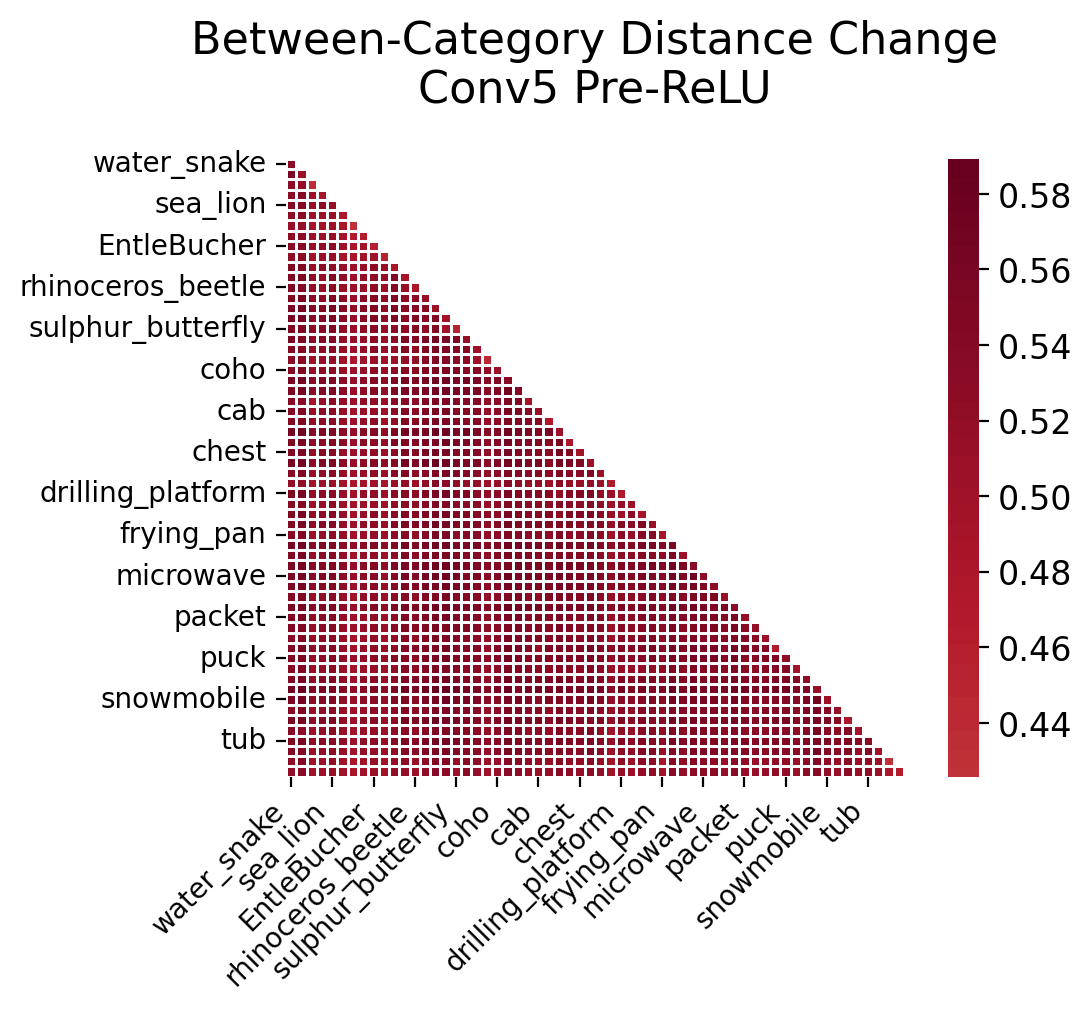

[feedforward_features_10]  avg shift=1.4289,  avg sep=0.0550,  Δsep=0.4201
[feedforward_features_10]  RSA ρ=0.895, p=0


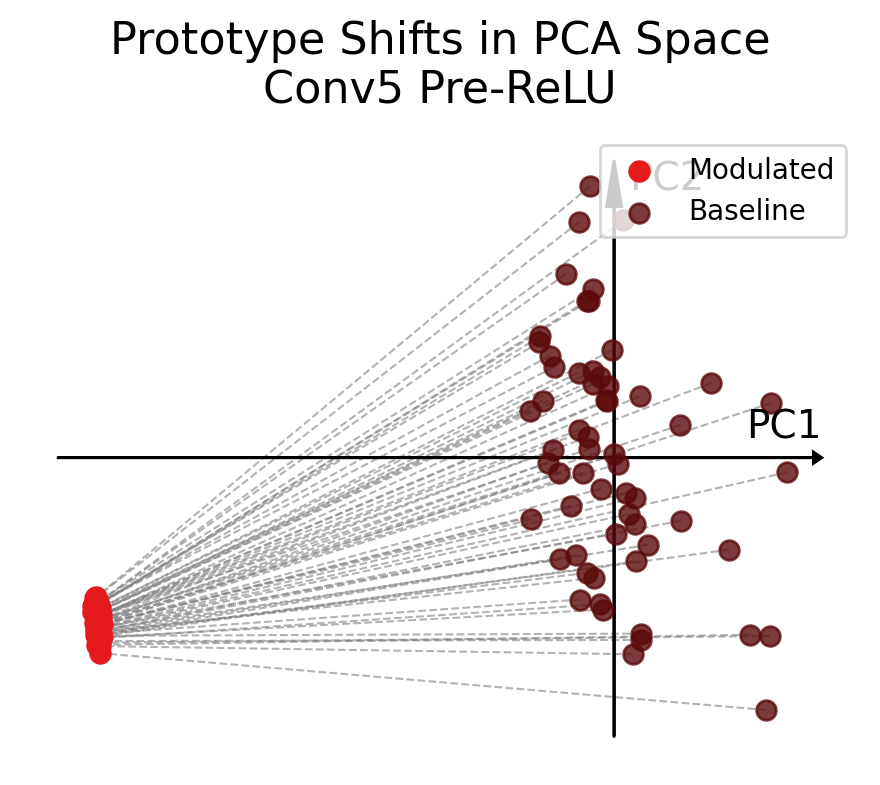

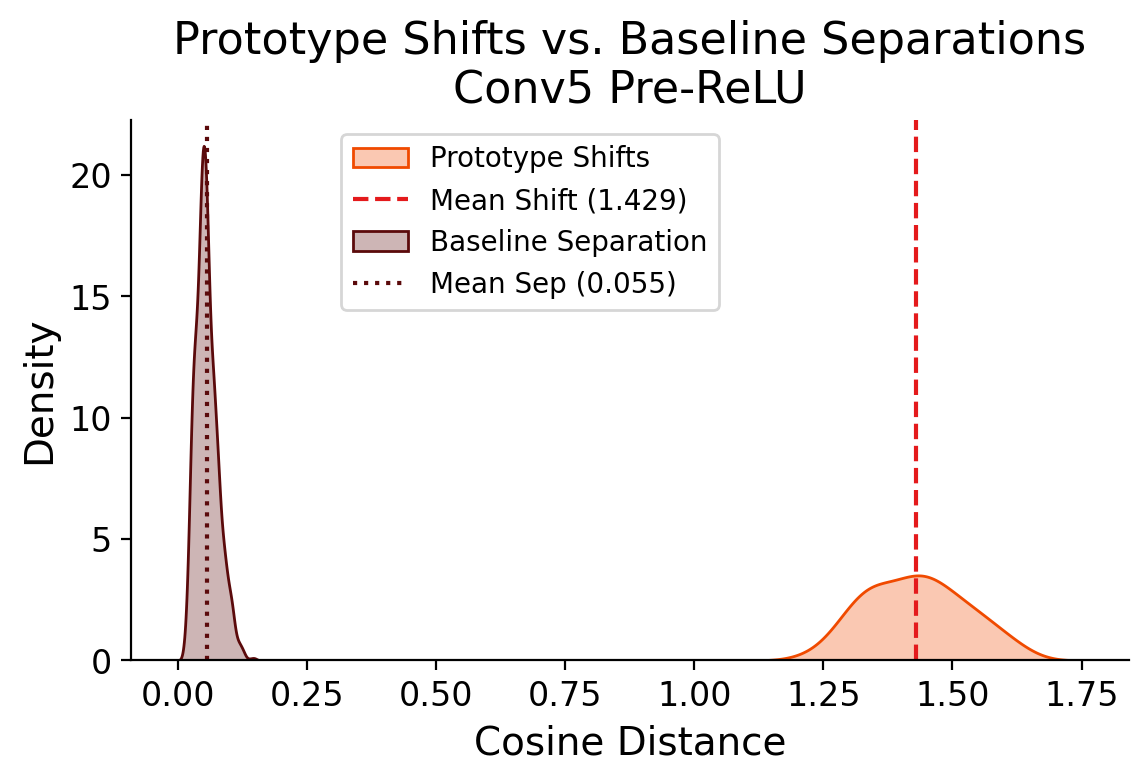

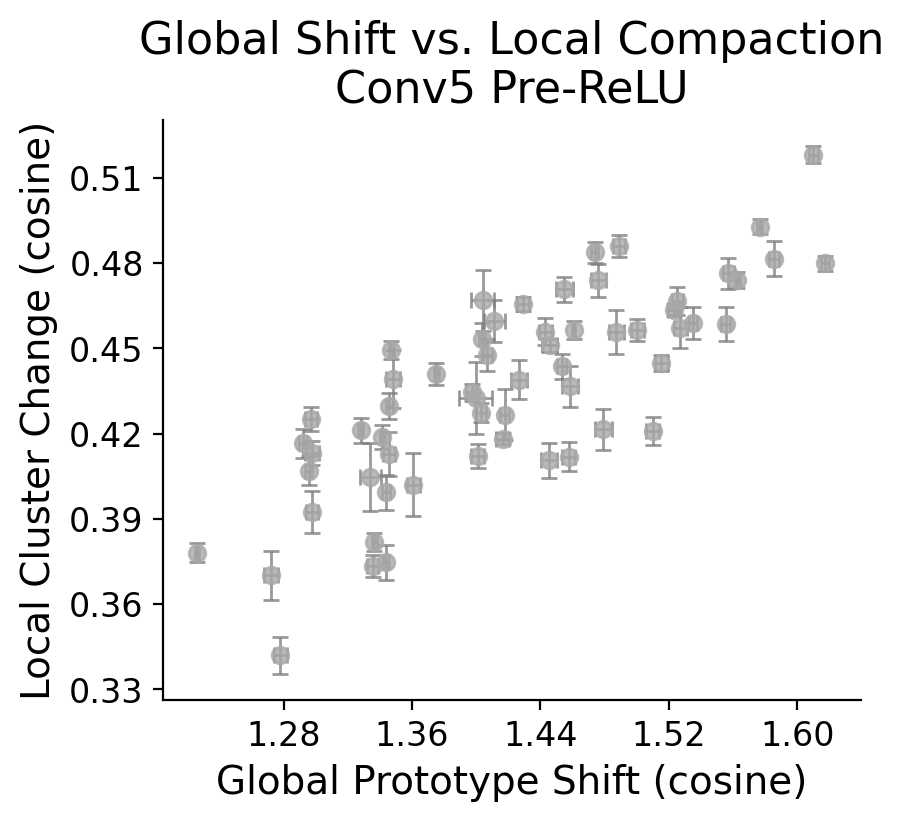





=== PROCESSING LAYER: feedforward_features_11 ===


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_diff
No. Observations: 6000    Method:             REML         
No. Groups:       60      Scale:              0.0004       
Min. group size:  100     Log-Likelihood:     15126.5940   
Max. group size:  100     Converged:          Yes          
Mean group size:  100.0                                    
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept   -0.035     0.001  -38.586  0.000  -0.037  -0.033
Group Var    0.000     0.000                                

One-tailed p-value: 0.0


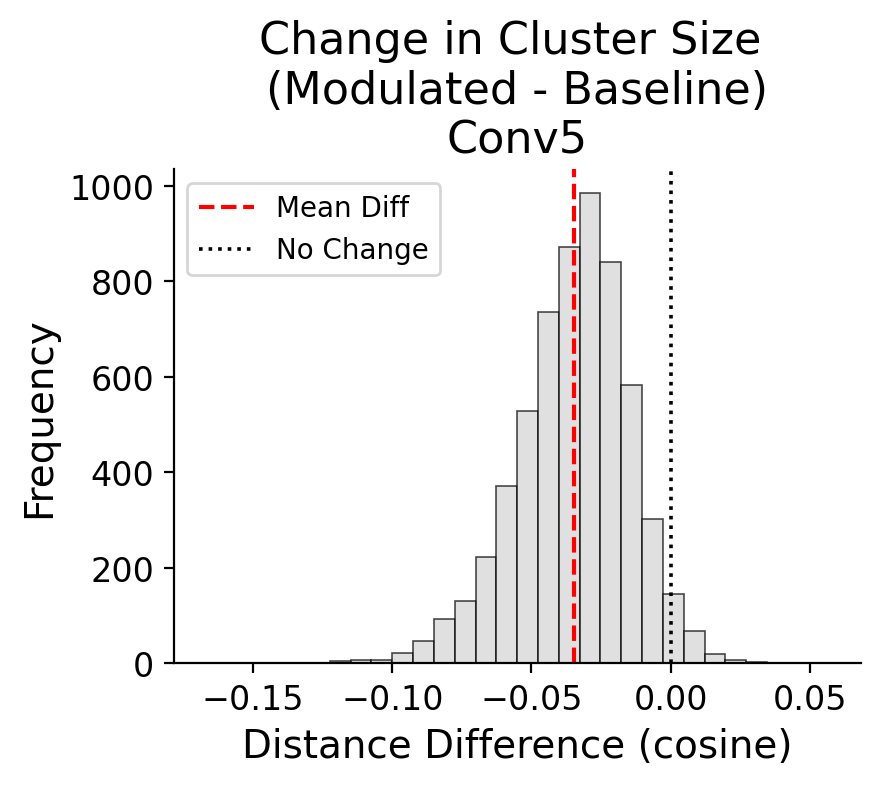

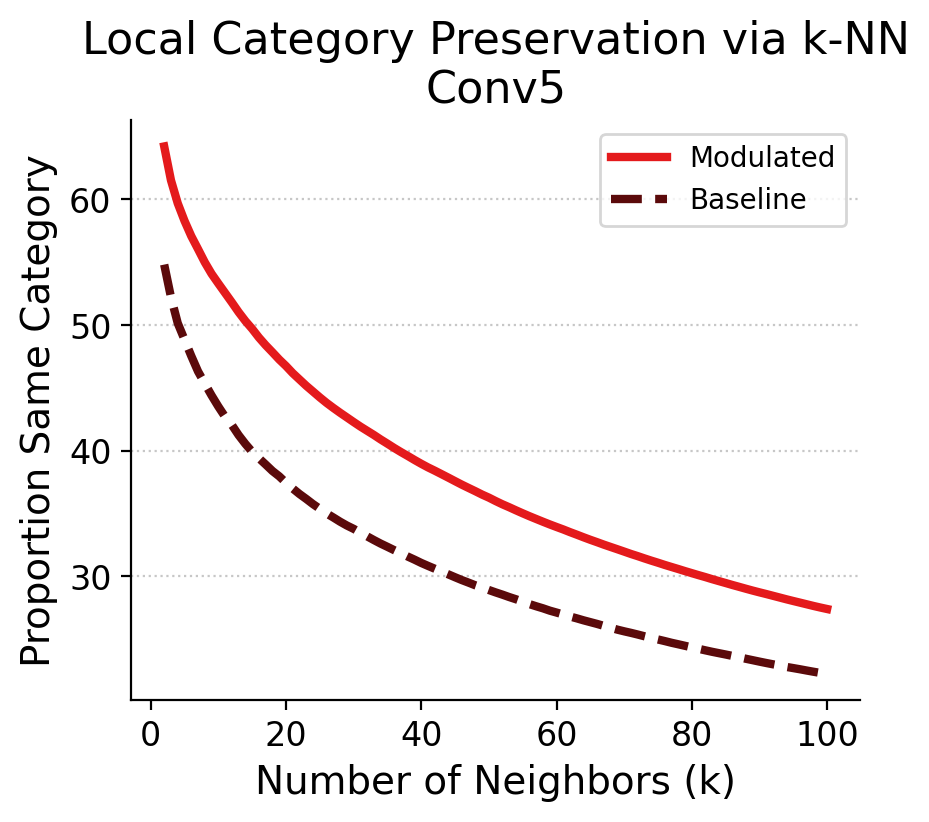

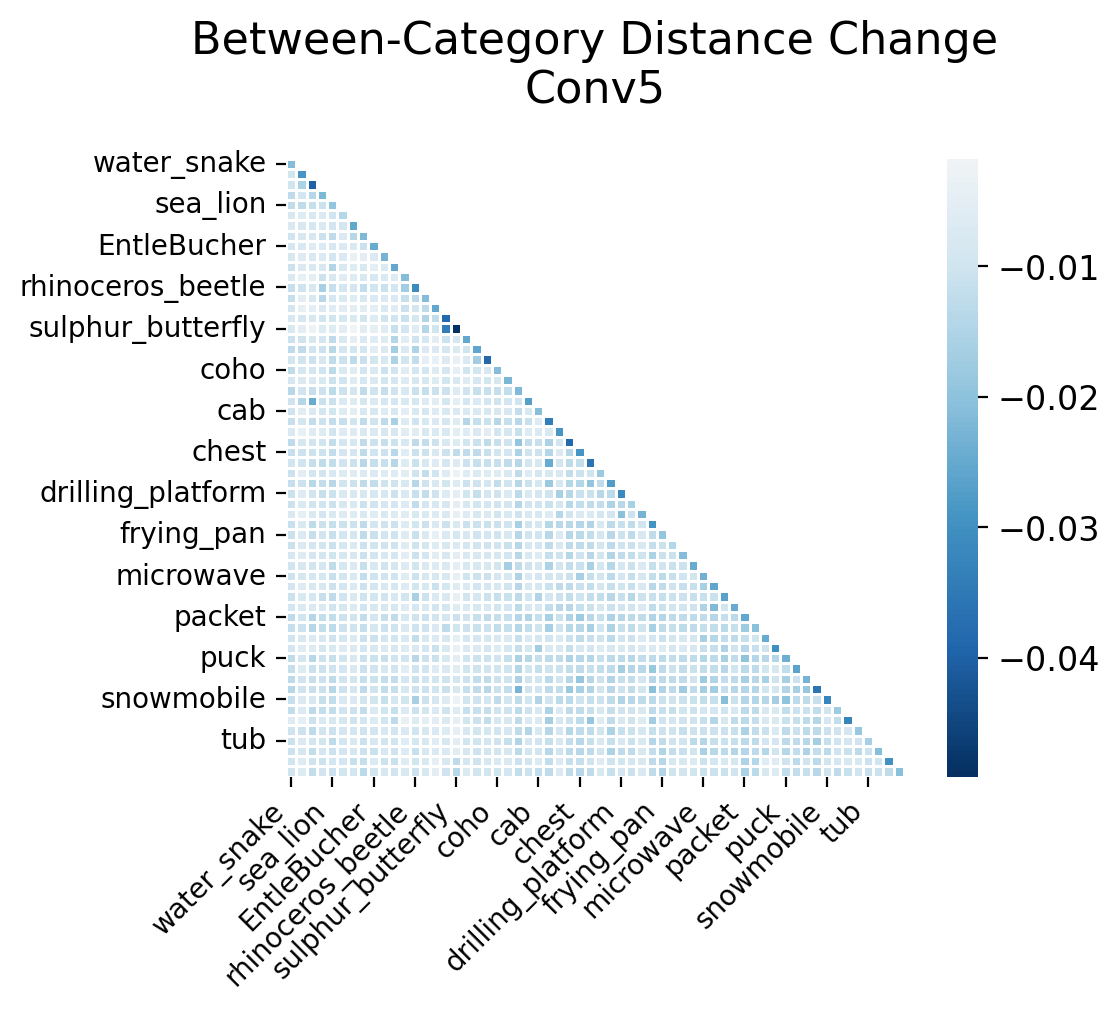

[feedforward_features_11]  avg shift=0.0214,  avg sep=0.4623,  Δsep=0.0128
[feedforward_features_11]  RSA ρ=0.986, p=0


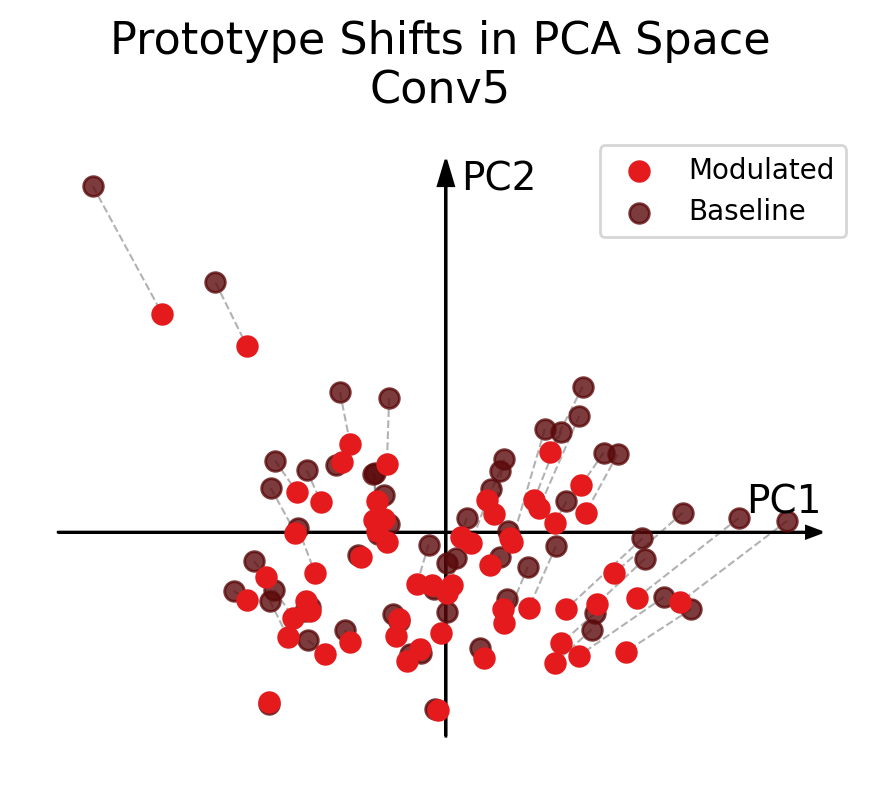

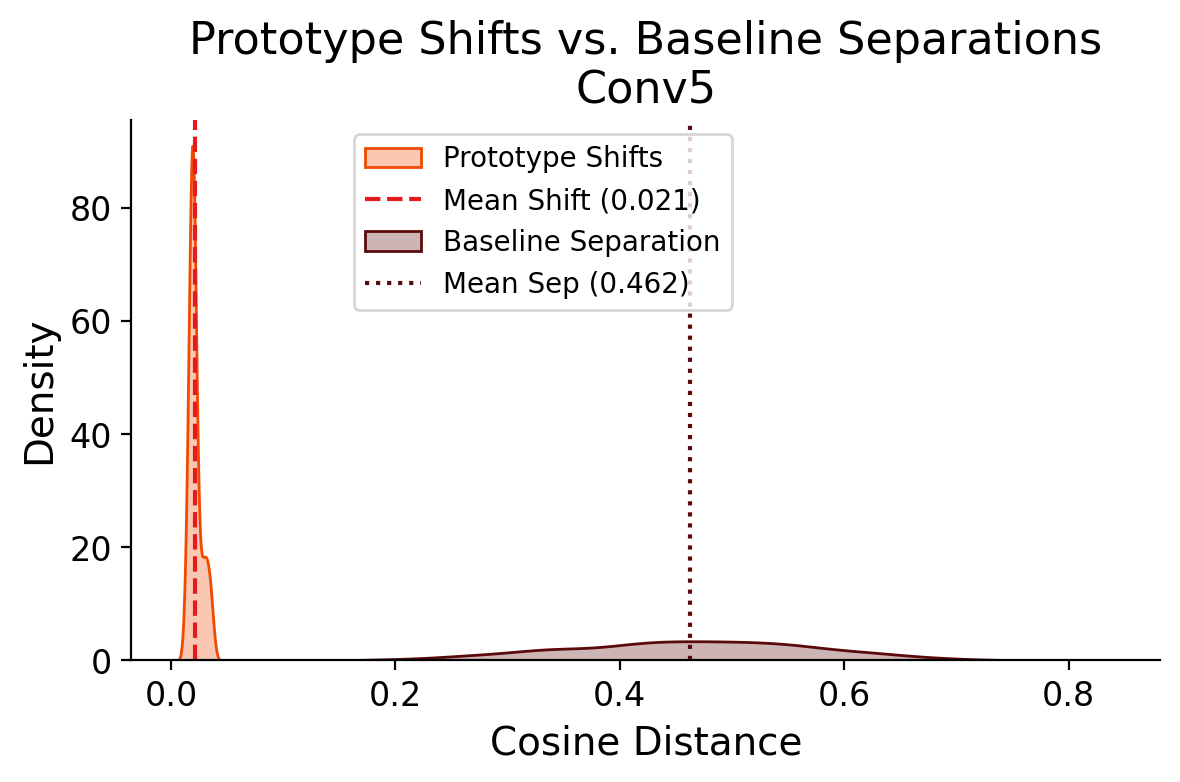

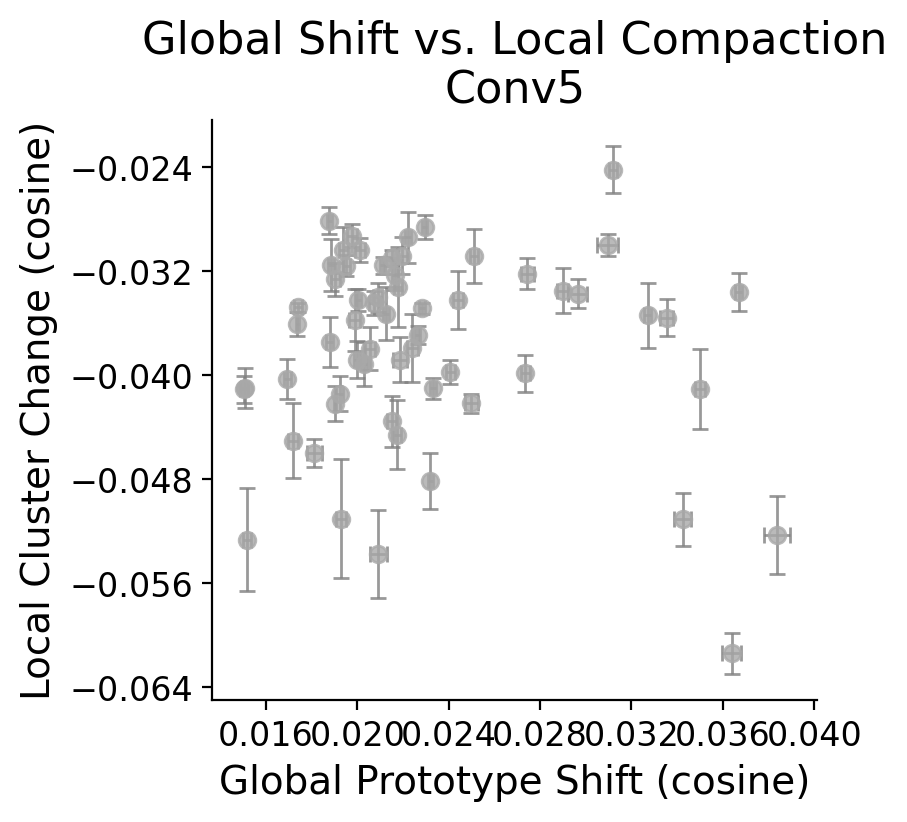





=== PROCESSING LAYER: feedforward_features_1 ===


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_diff
No. Observations: 6000    Method:             REML         
No. Groups:       60      Scale:              0.0002       
Min. group size:  100     Log-Likelihood:     17046.3246   
Max. group size:  100     Converged:          Yes          
Mean group size:  100.0                                    
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept   -0.012     0.001  -13.048  0.000  -0.014  -0.010
Group Var    0.000     0.001                                

One-tailed p-value: 3.2649598342095036e-39


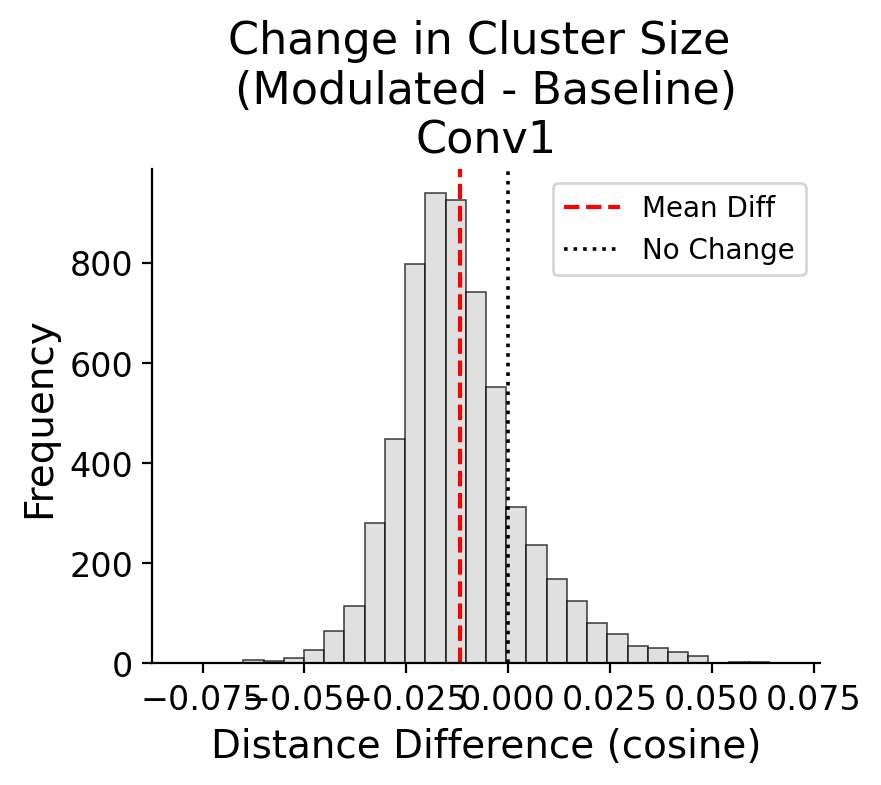

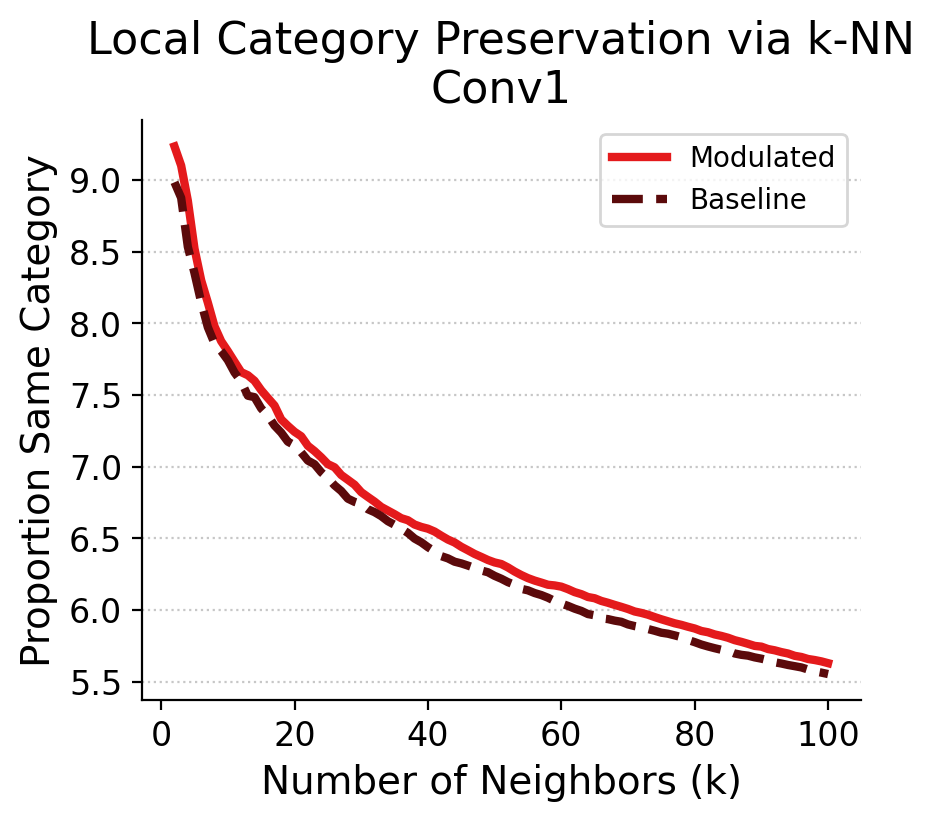

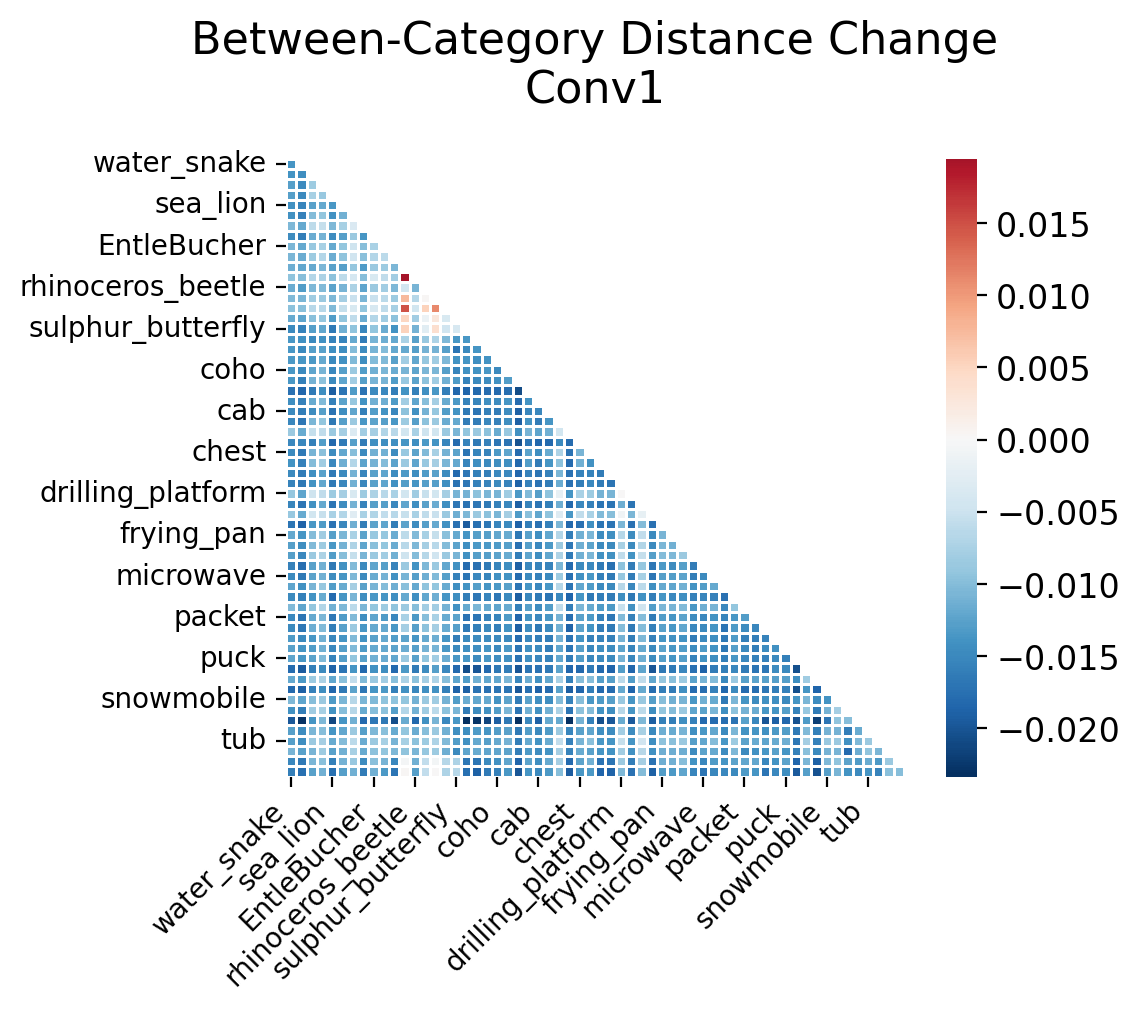

[feedforward_features_1]  avg shift=0.0117,  avg sep=0.1346,  Δsep=-0.0136
[feedforward_features_1]  RSA ρ=0.988, p=0


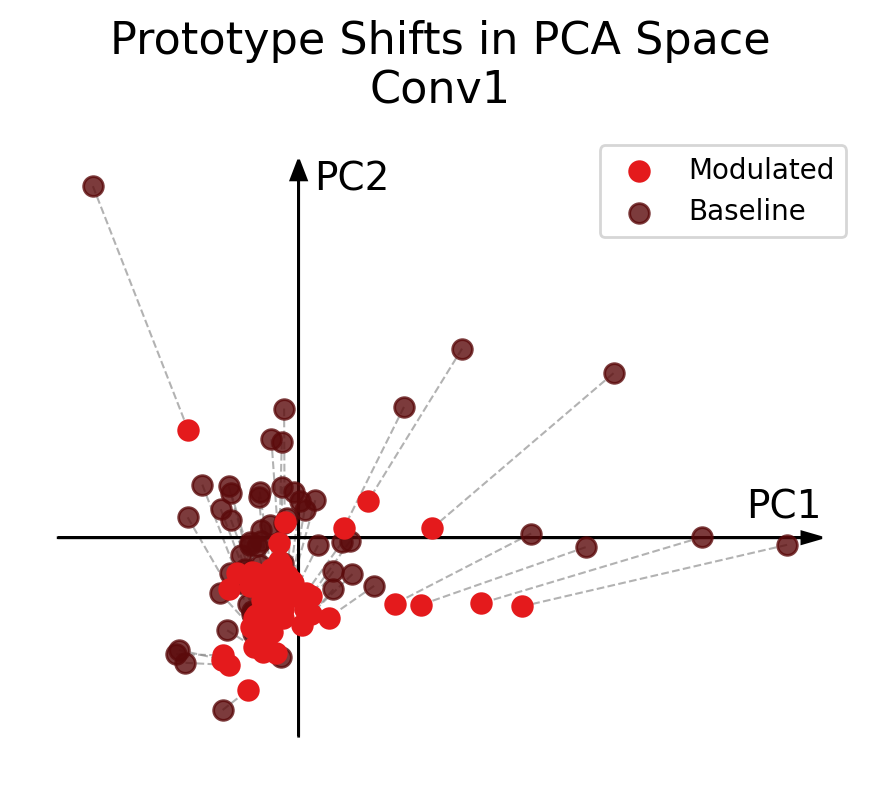

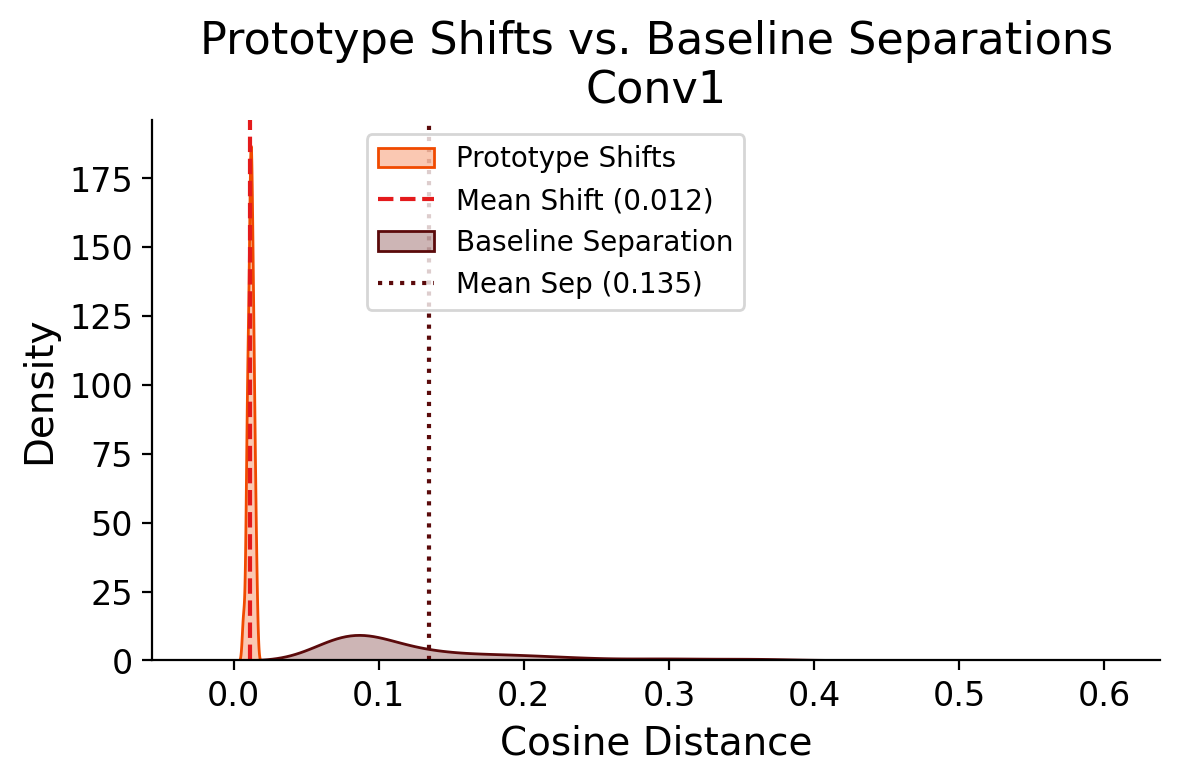

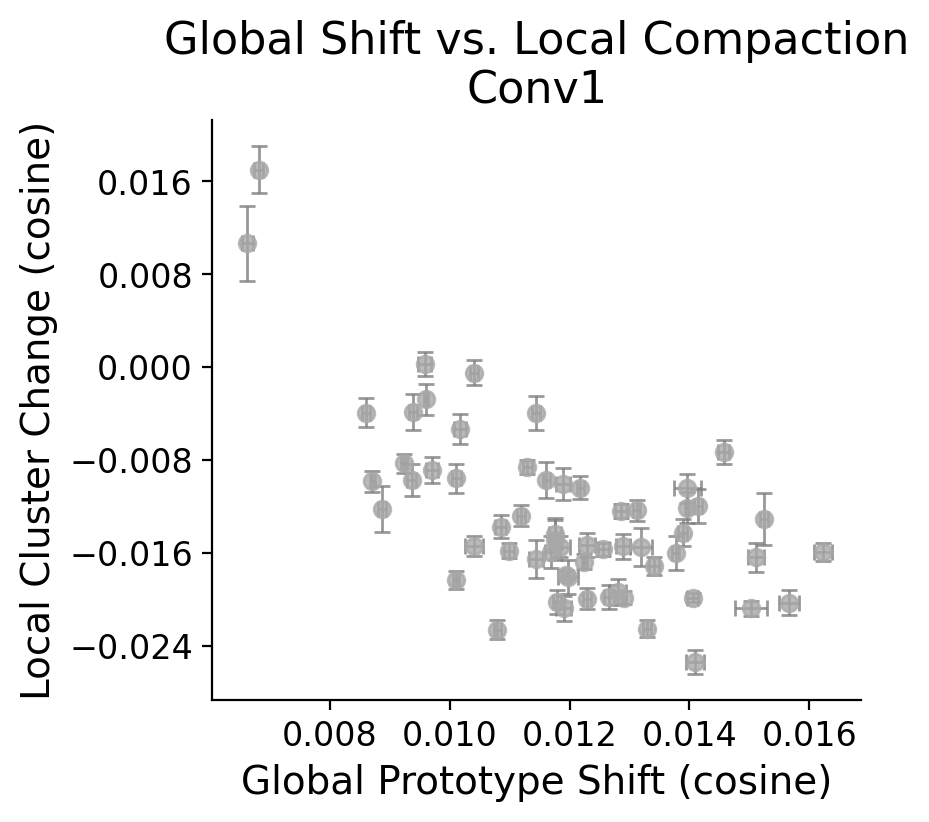





=== PROCESSING LAYER: feedforward_features_4 ===


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_diff
No. Observations: 6000    Method:             REML         
No. Groups:       60      Scale:              0.0003       
Min. group size:  100     Log-Likelihood:     15781.9511   
Max. group size:  100     Converged:          Yes          
Mean group size:  100.0                                    
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept   -0.028     0.001  -27.434  0.000  -0.030  -0.026
Group Var    0.000     0.001                                

One-tailed p-value: 5.3346710309249585e-166


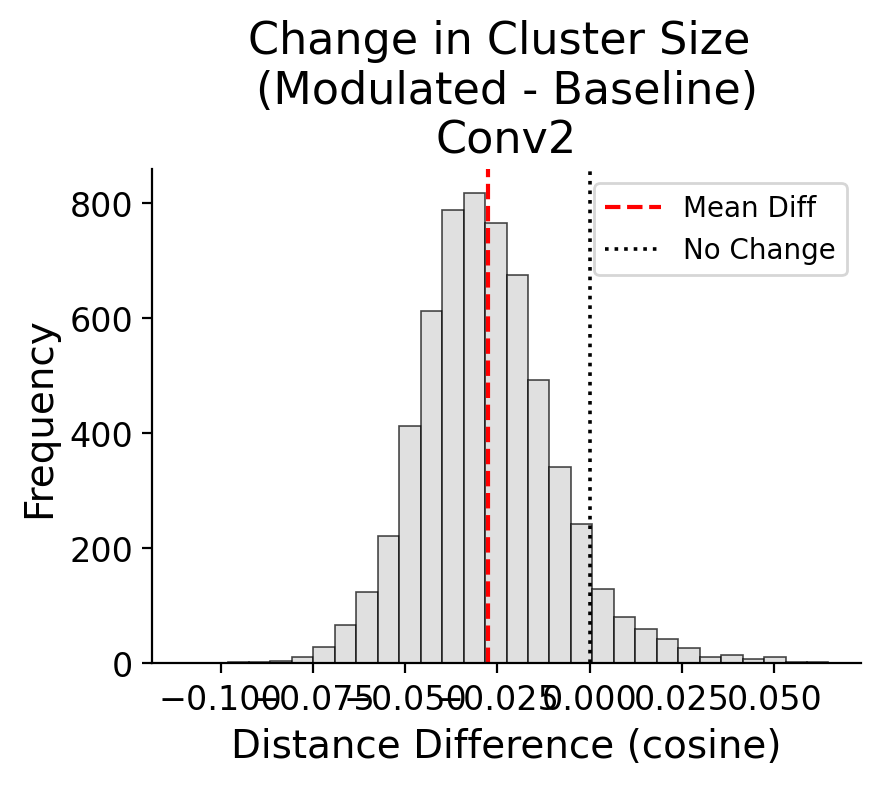

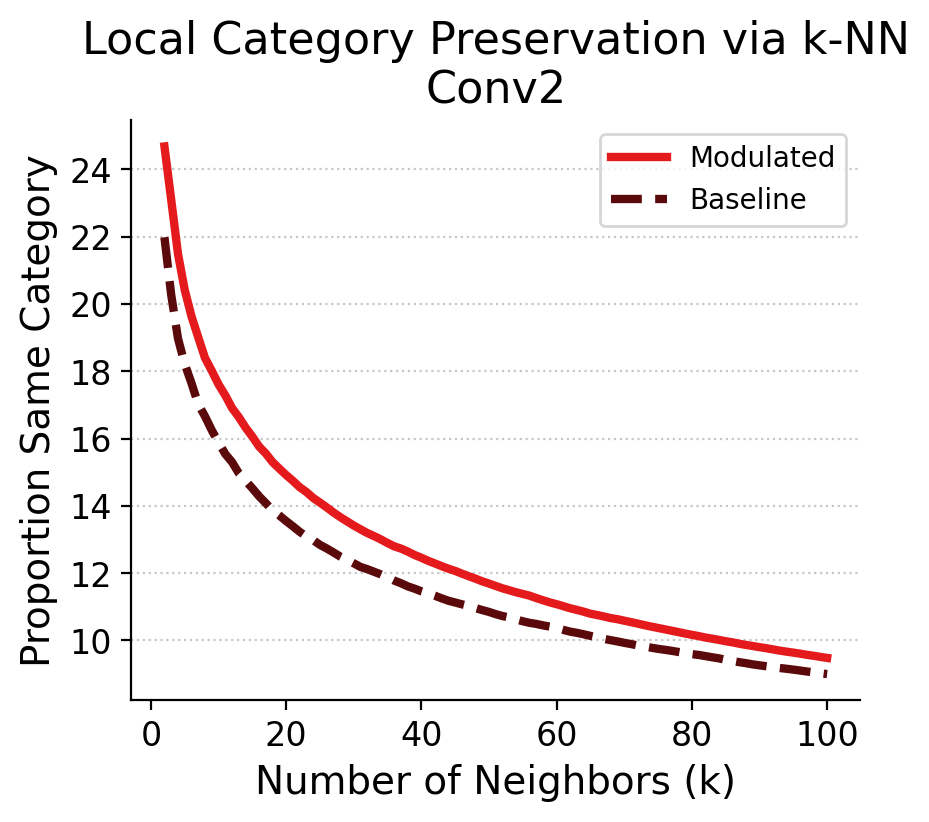

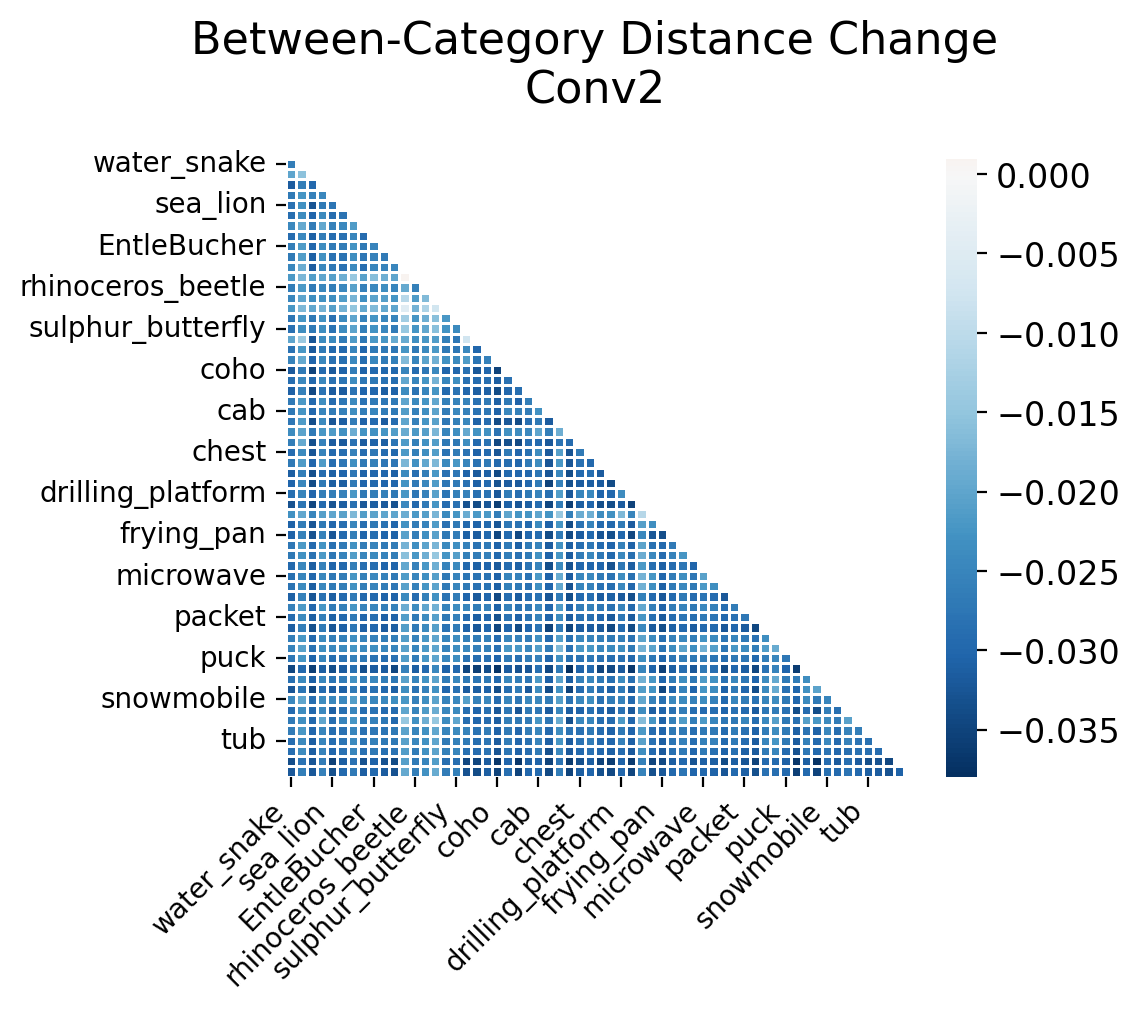

[feedforward_features_4]  avg shift=0.0414,  avg sep=0.1592,  Δsep=-0.0241
[feedforward_features_4]  RSA ρ=0.983, p=0


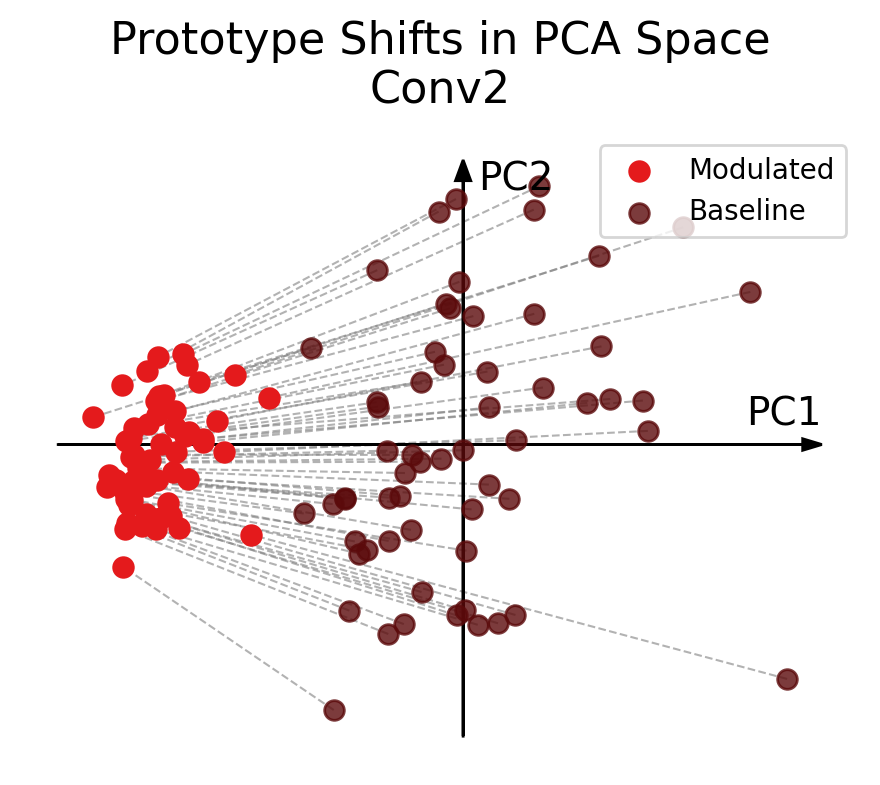

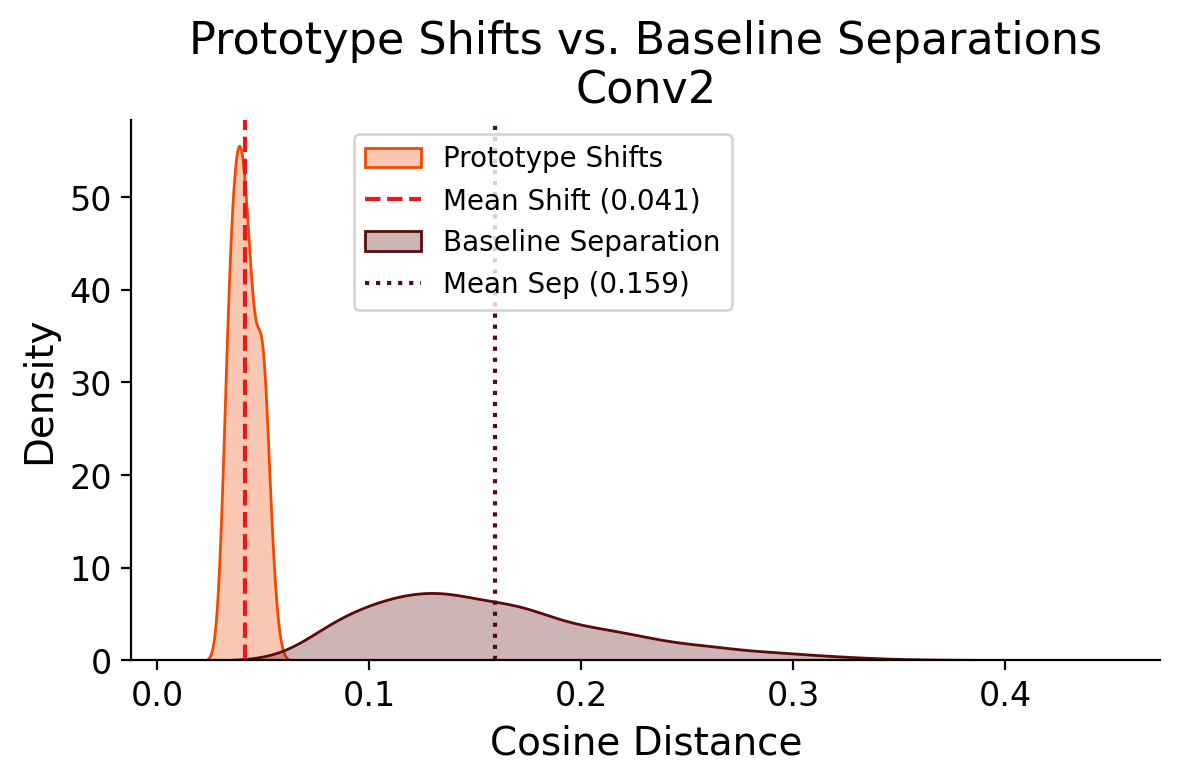

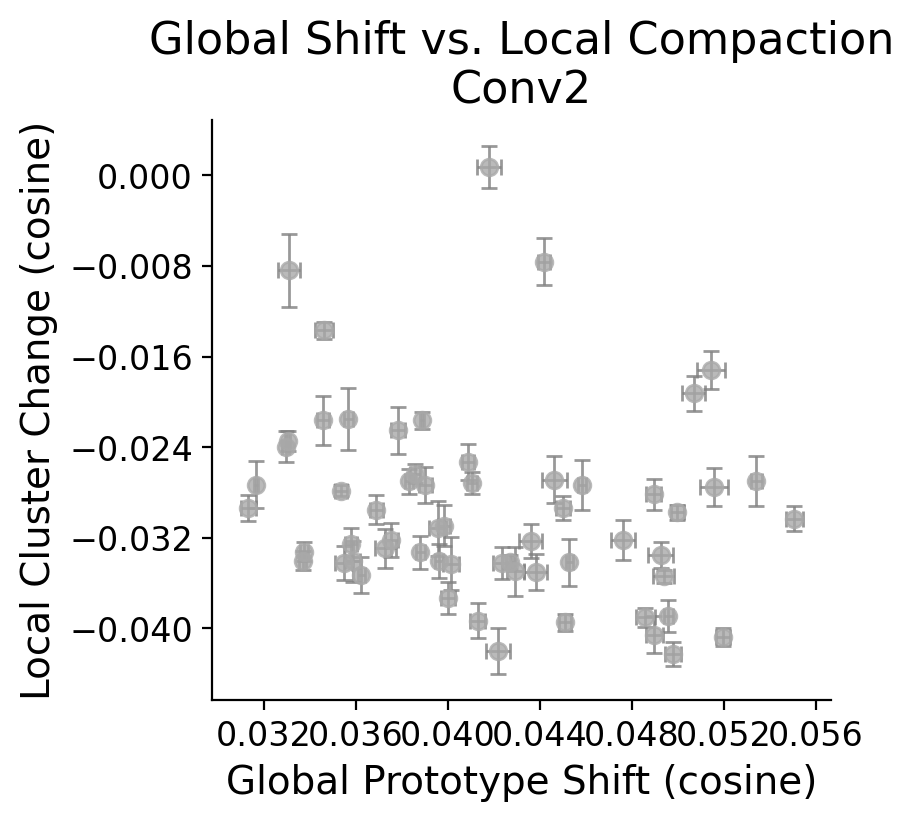





=== PROCESSING LAYER: feedforward_features_6 ===


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_diff
No. Observations: 6000    Method:             REML         
No. Groups:       60      Scale:              0.0021       
Min. group size:  100     Log-Likelihood:     9941.8028    
Max. group size:  100     Converged:          Yes          
Mean group size:  100.0                                    
------------------------------------------------------------
              Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     0.236     0.003  79.619  0.000   0.230   0.241
Group Var     0.001     0.002                               

One-tailed p-value: 1.0


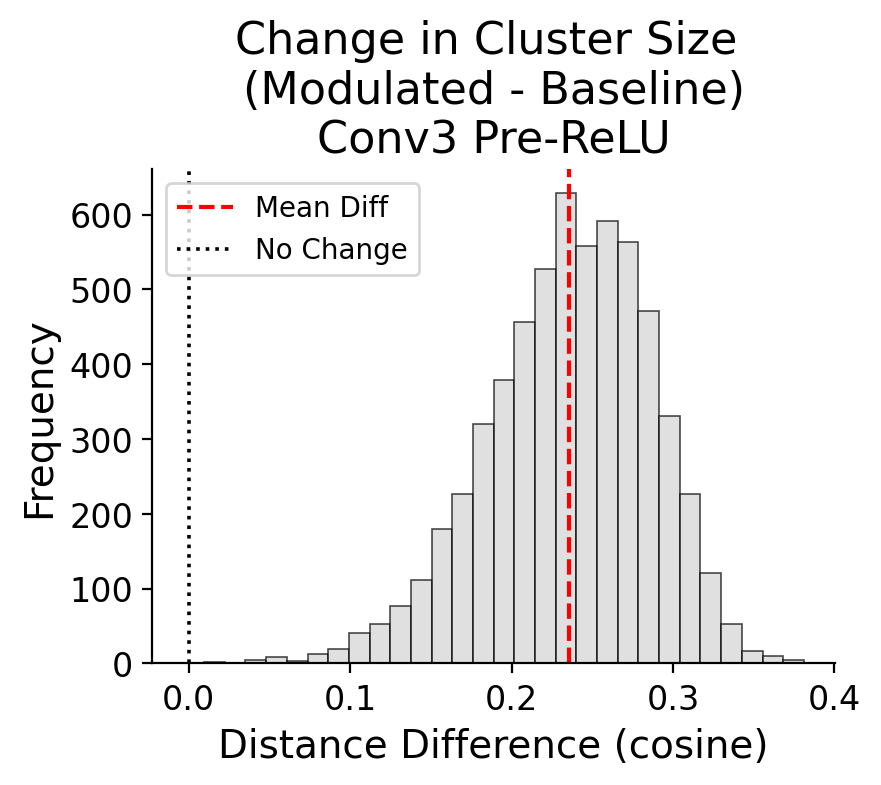

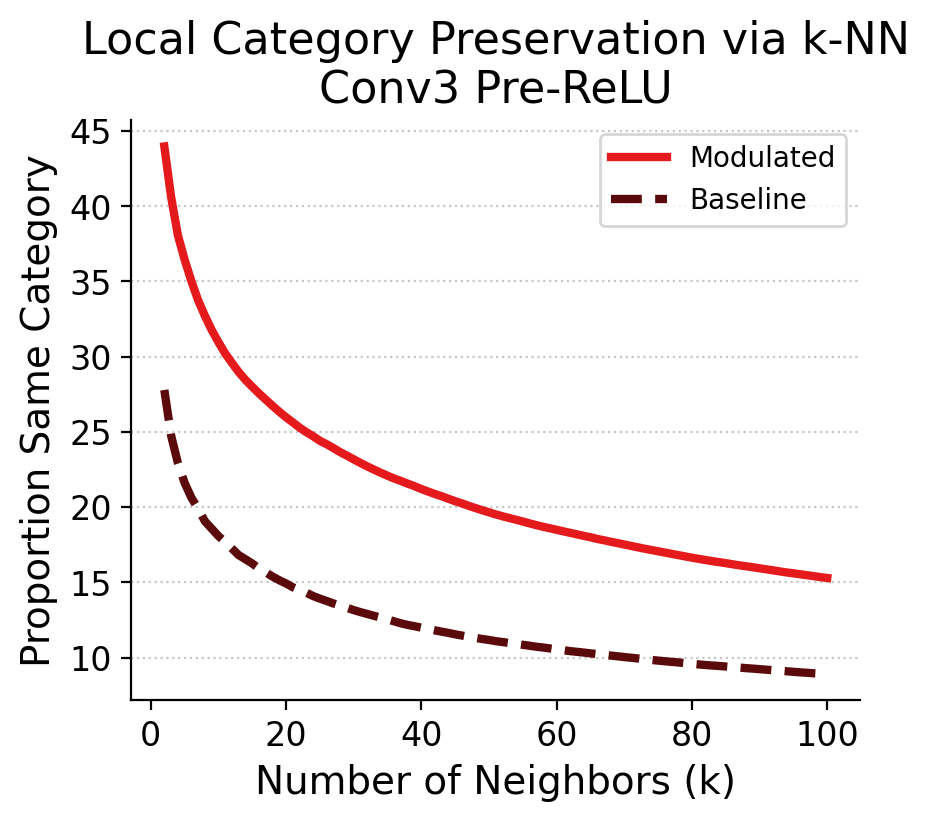

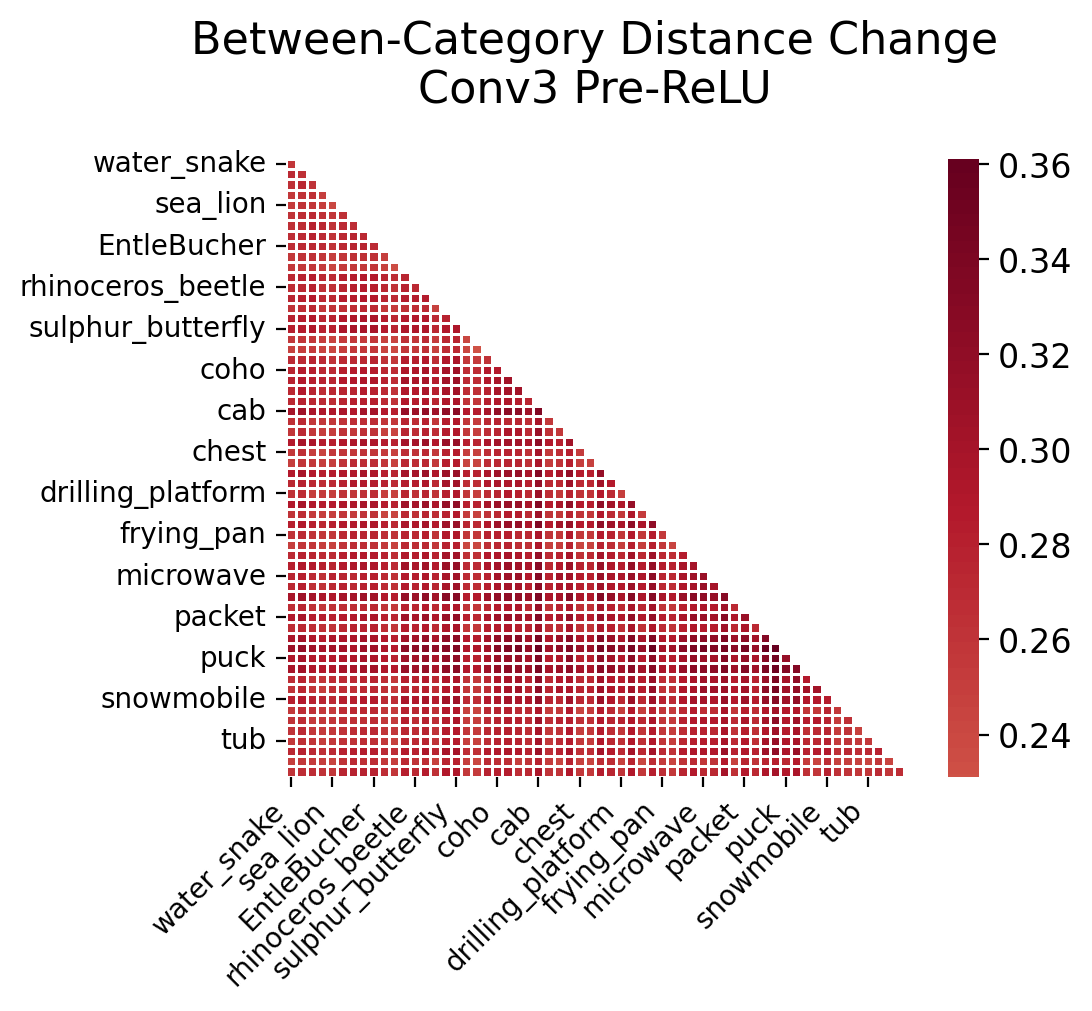

[feedforward_features_6]  avg shift=1.3929,  avg sep=0.0698,  Δsep=0.1095
[feedforward_features_6]  RSA ρ=0.904, p=0


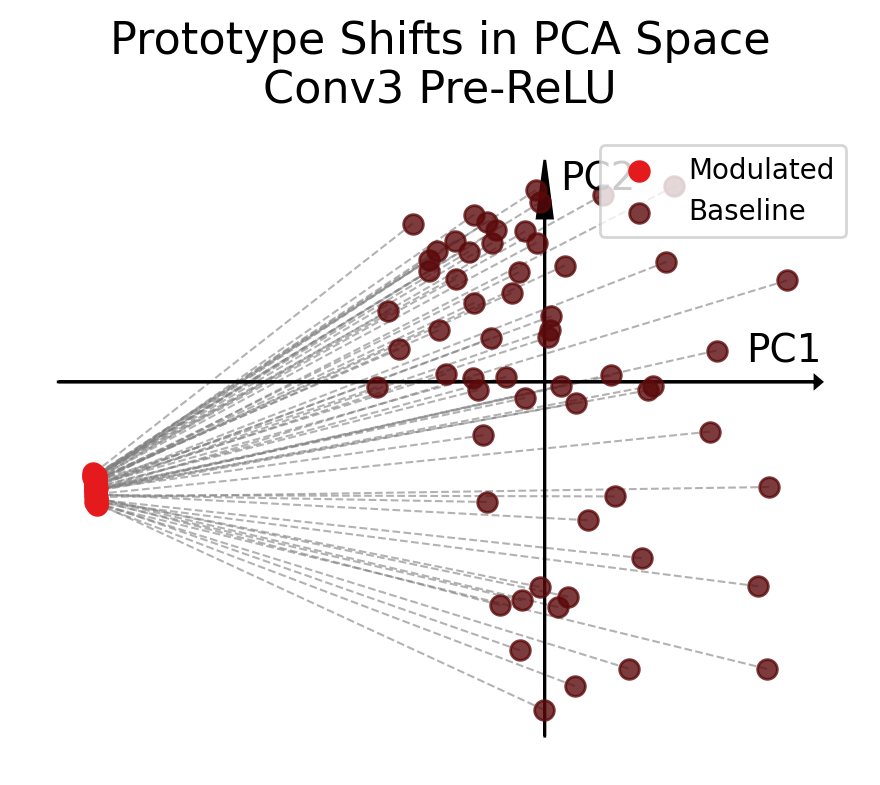

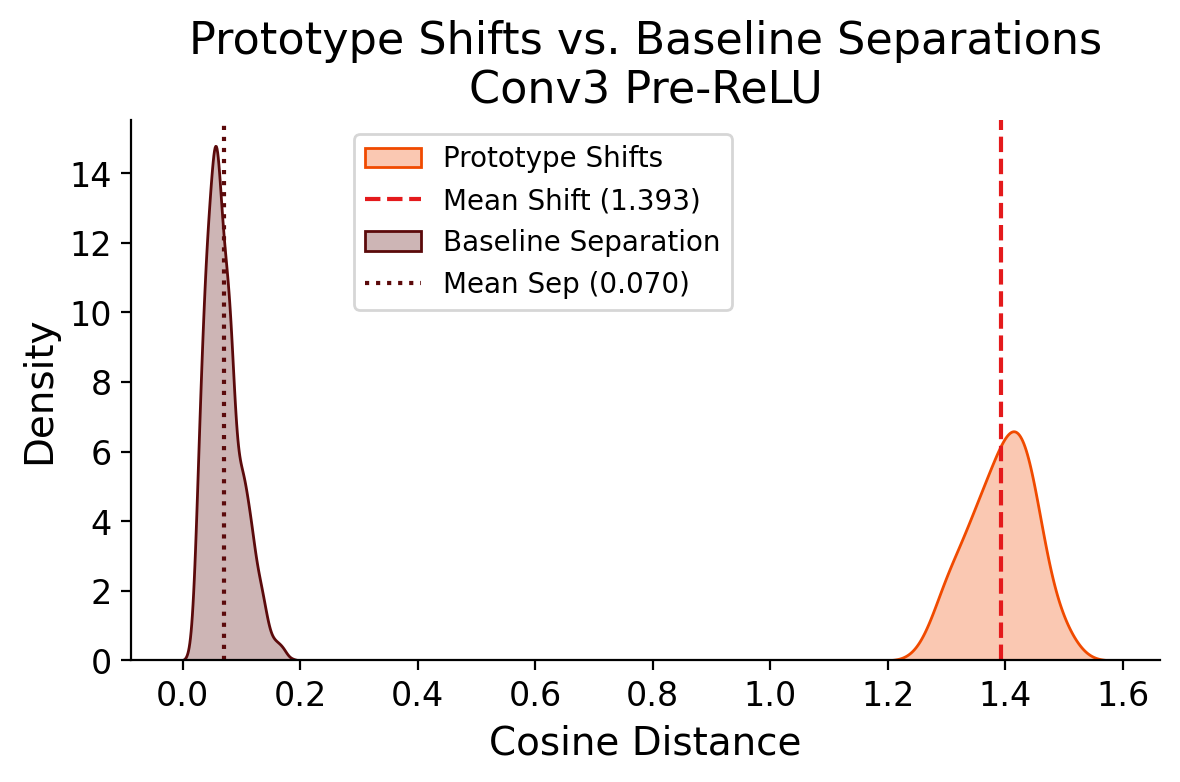

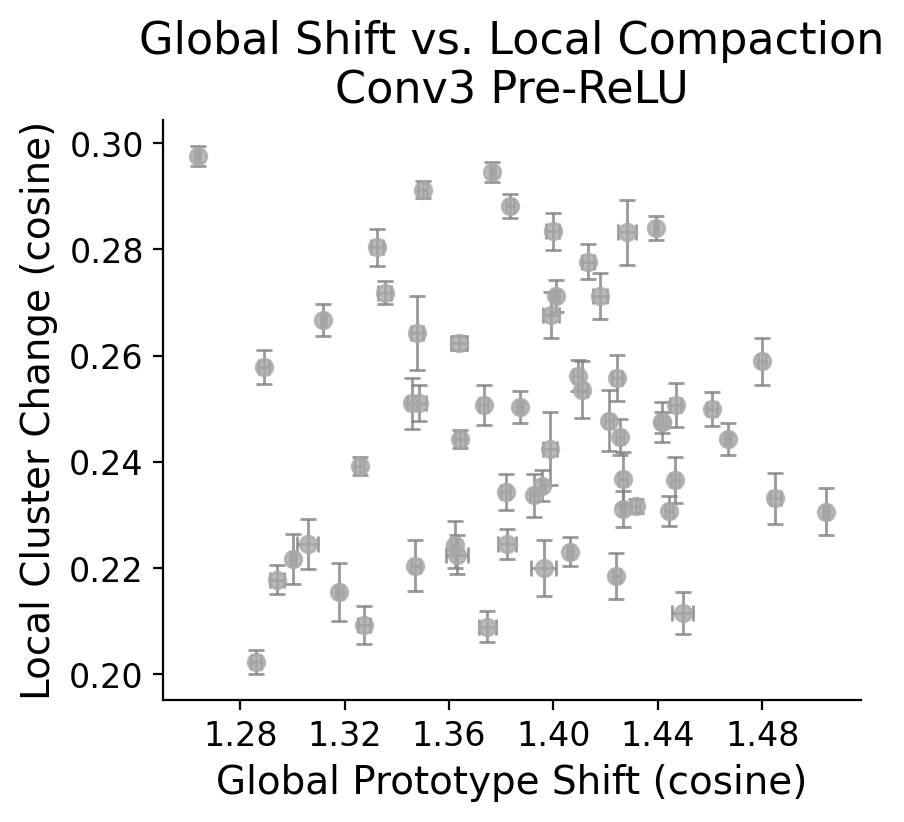





=== PROCESSING LAYER: feedforward_features_7 ===


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_diff
No. Observations: 6000    Method:             REML         
No. Groups:       60      Scale:              0.0002       
Min. group size:  100     Log-Likelihood:     17409.2219   
Max. group size:  100     Converged:          Yes          
Mean group size:  100.0                                    
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept   -0.038     0.001  -52.180  0.000  -0.040  -0.037
Group Var    0.000     0.000                                

One-tailed p-value: 0.0


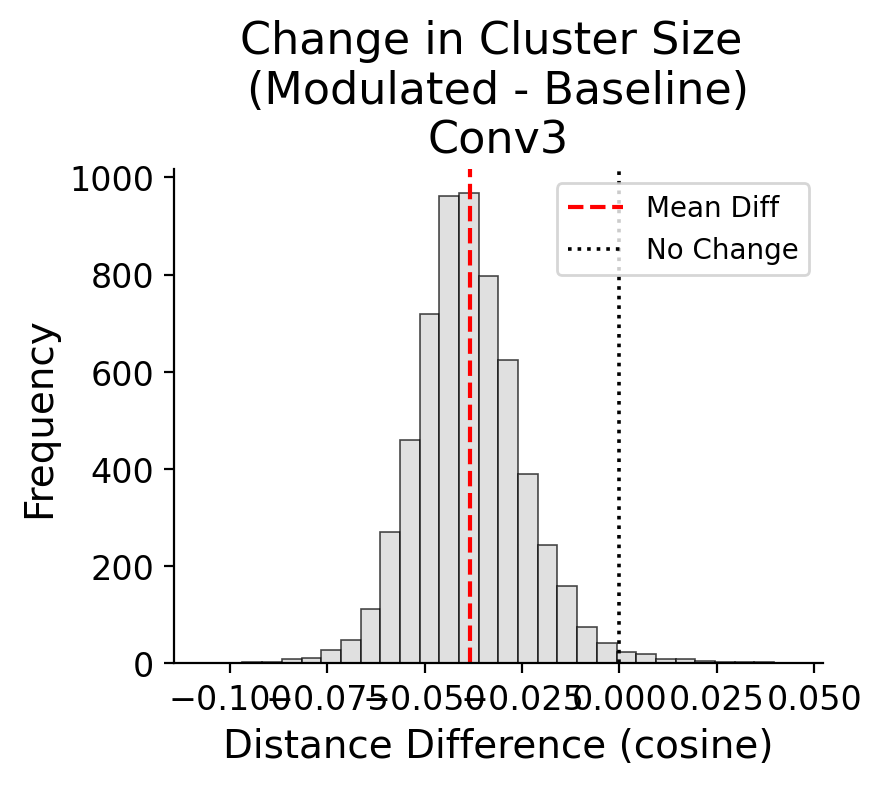

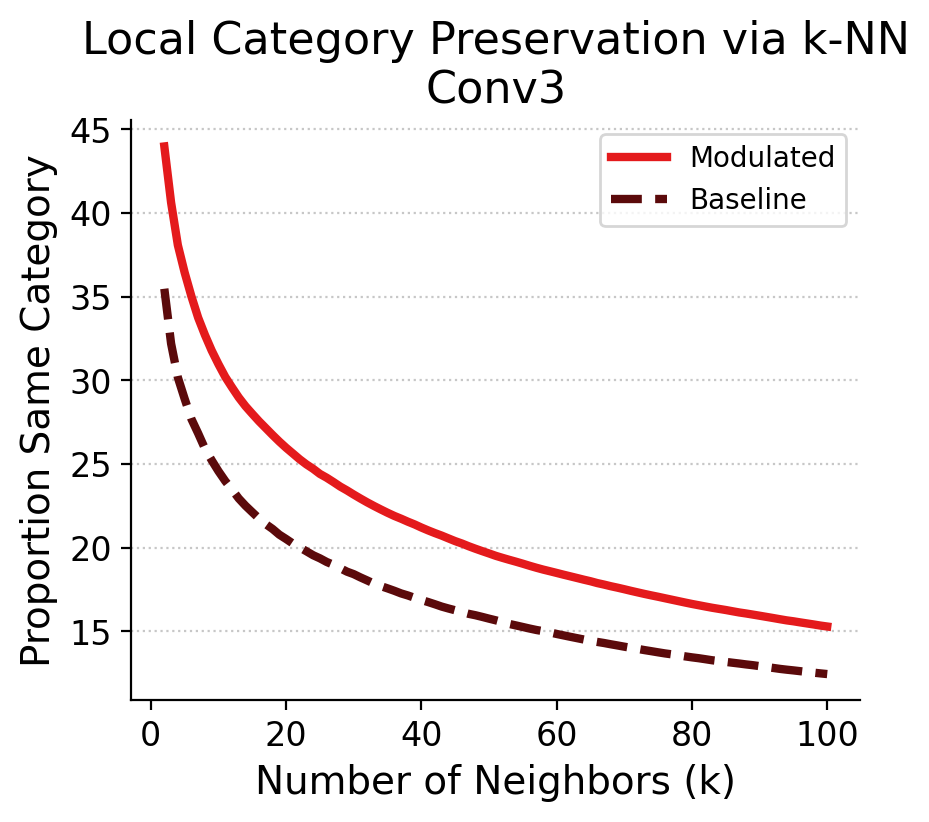

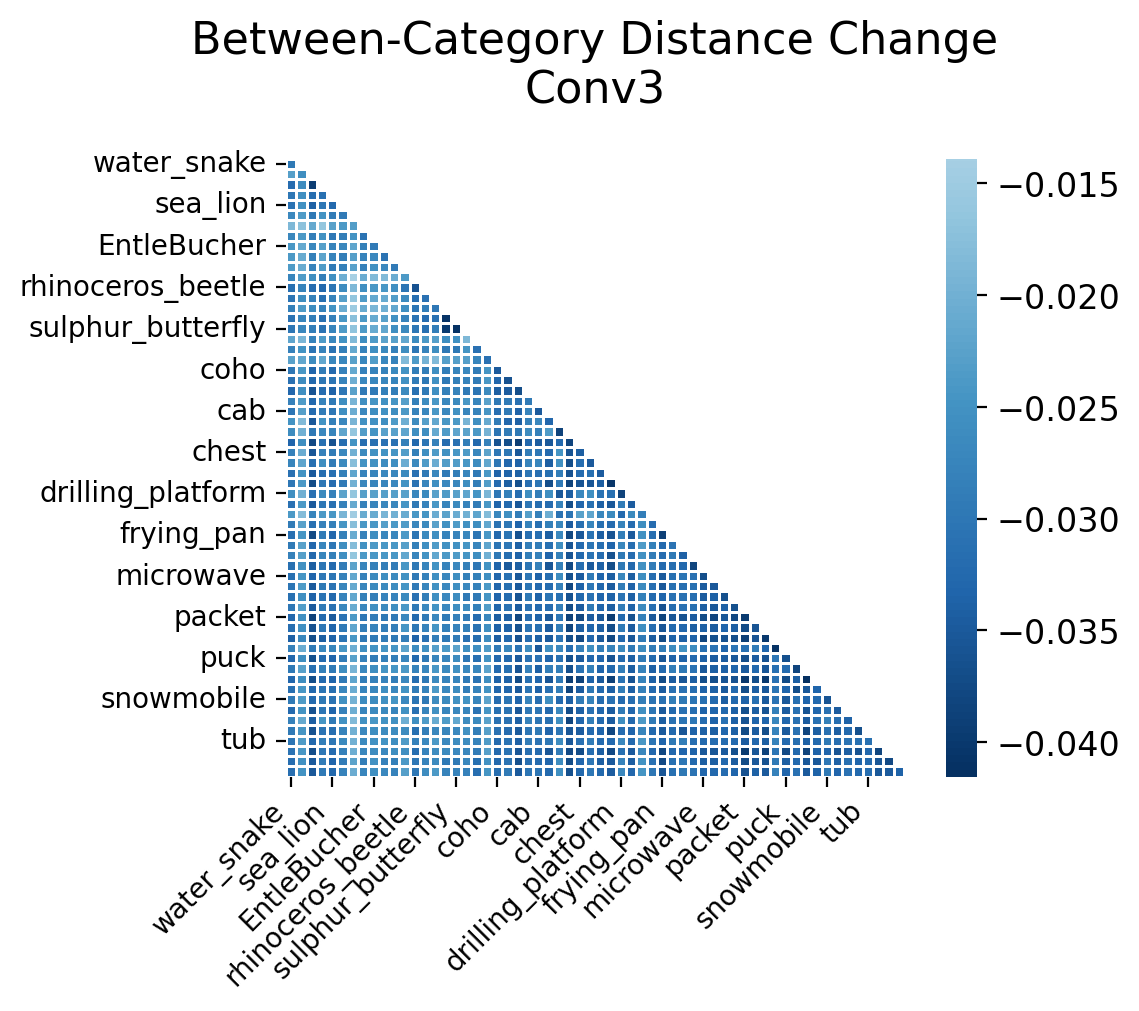

[feedforward_features_7]  avg shift=0.0408,  avg sep=0.1886,  Δsep=-0.0093
[feedforward_features_7]  RSA ρ=0.970, p=0


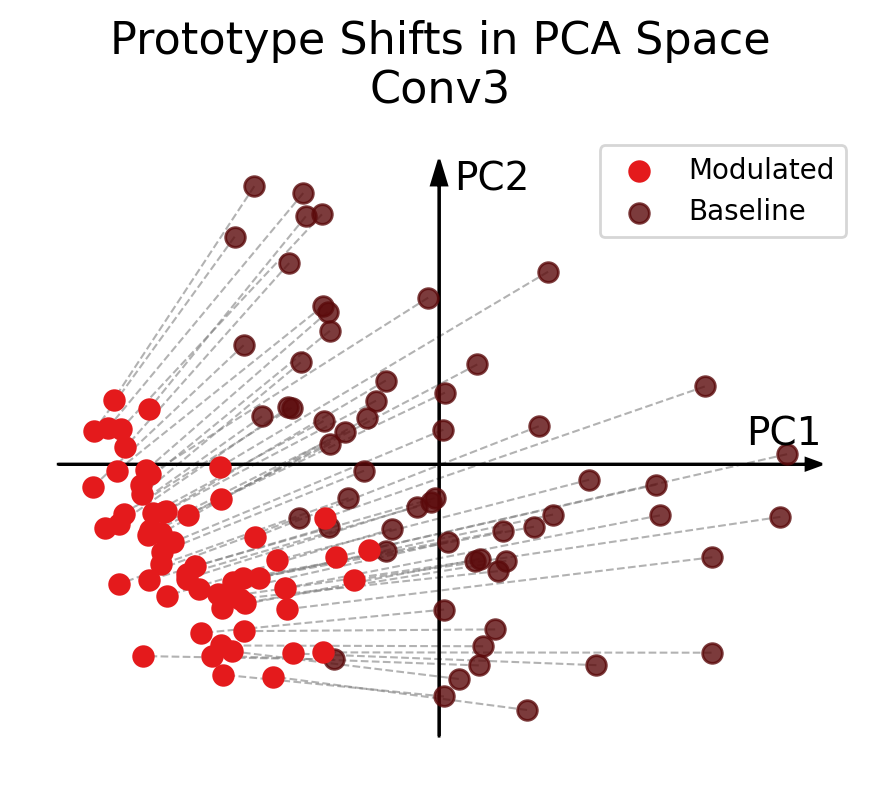

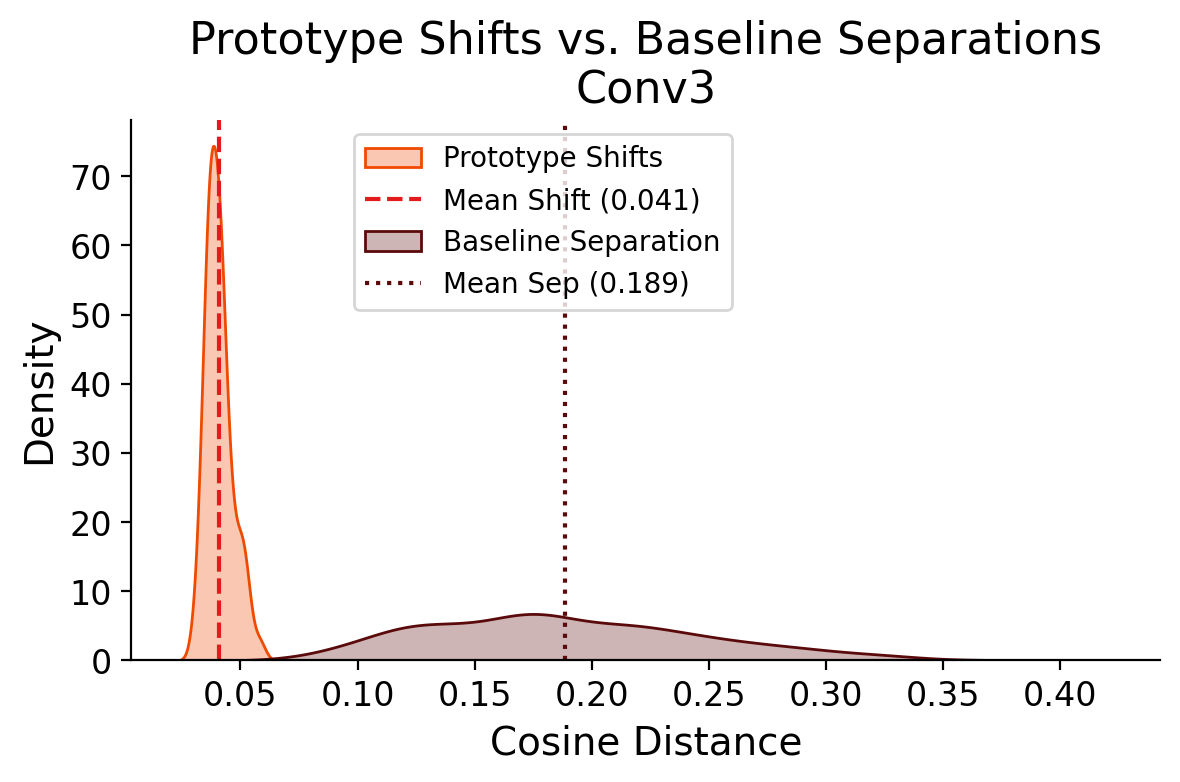

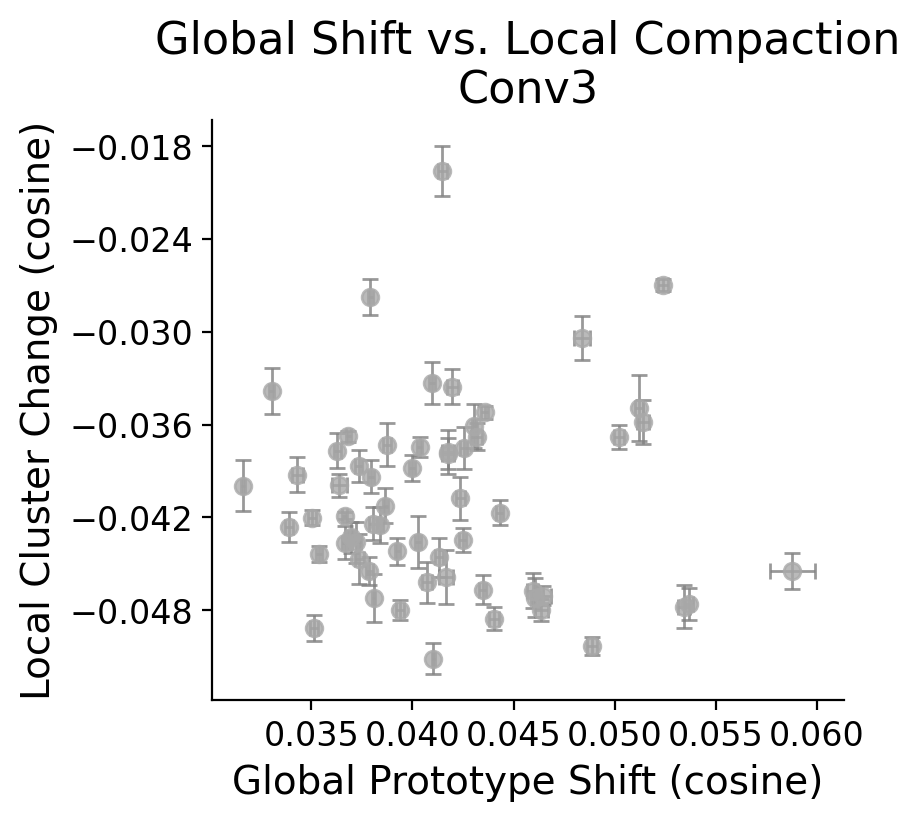





=== PROCESSING LAYER: feedforward_features_9 ===


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_diff
No. Observations: 6000    Method:             REML         
No. Groups:       60      Scale:              0.0002       
Min. group size:  100     Log-Likelihood:     16820.5448   
Max. group size:  100     Converged:          Yes          
Mean group size:  100.0                                    
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept   -0.037     0.001  -37.454  0.000  -0.039  -0.035
Group Var    0.000     0.001                                

One-tailed p-value: 2.571555643863782e-307


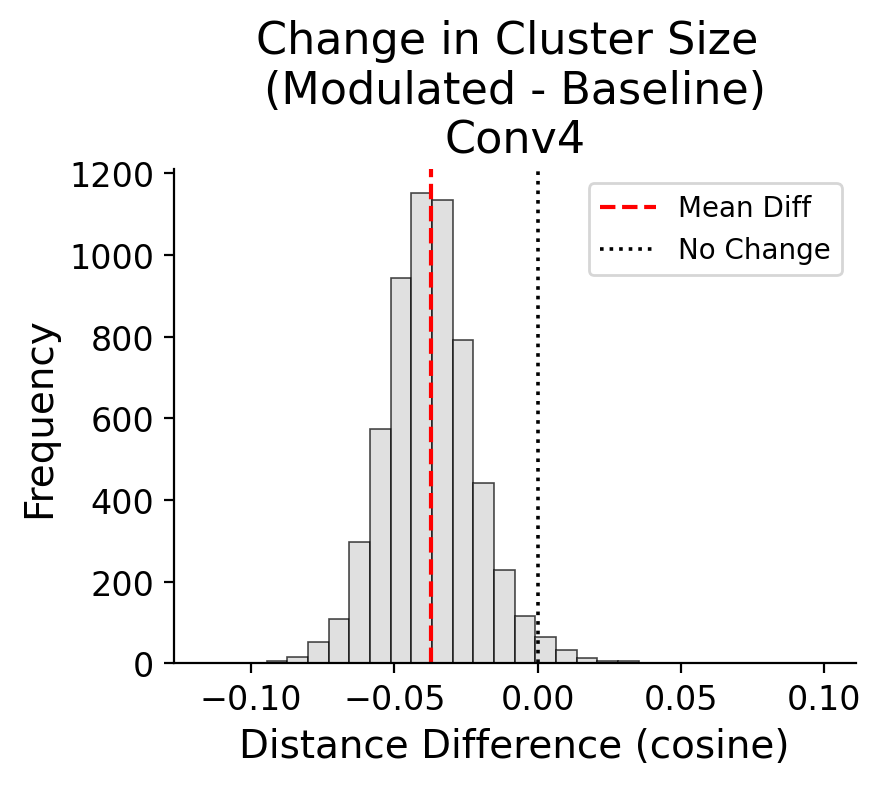

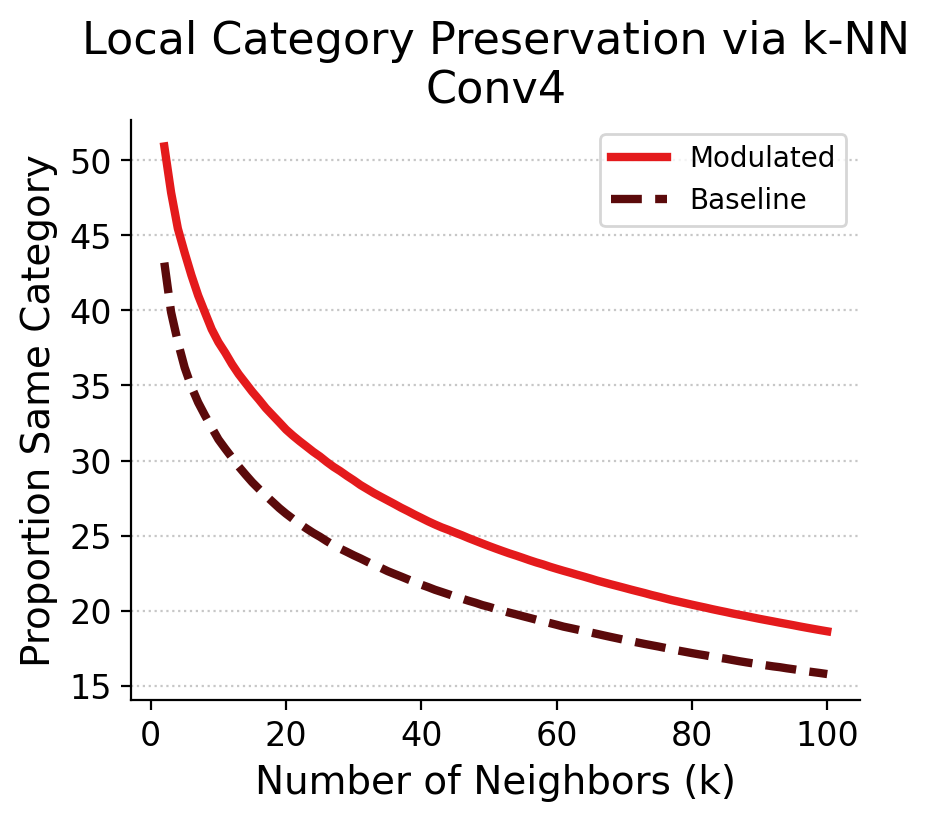

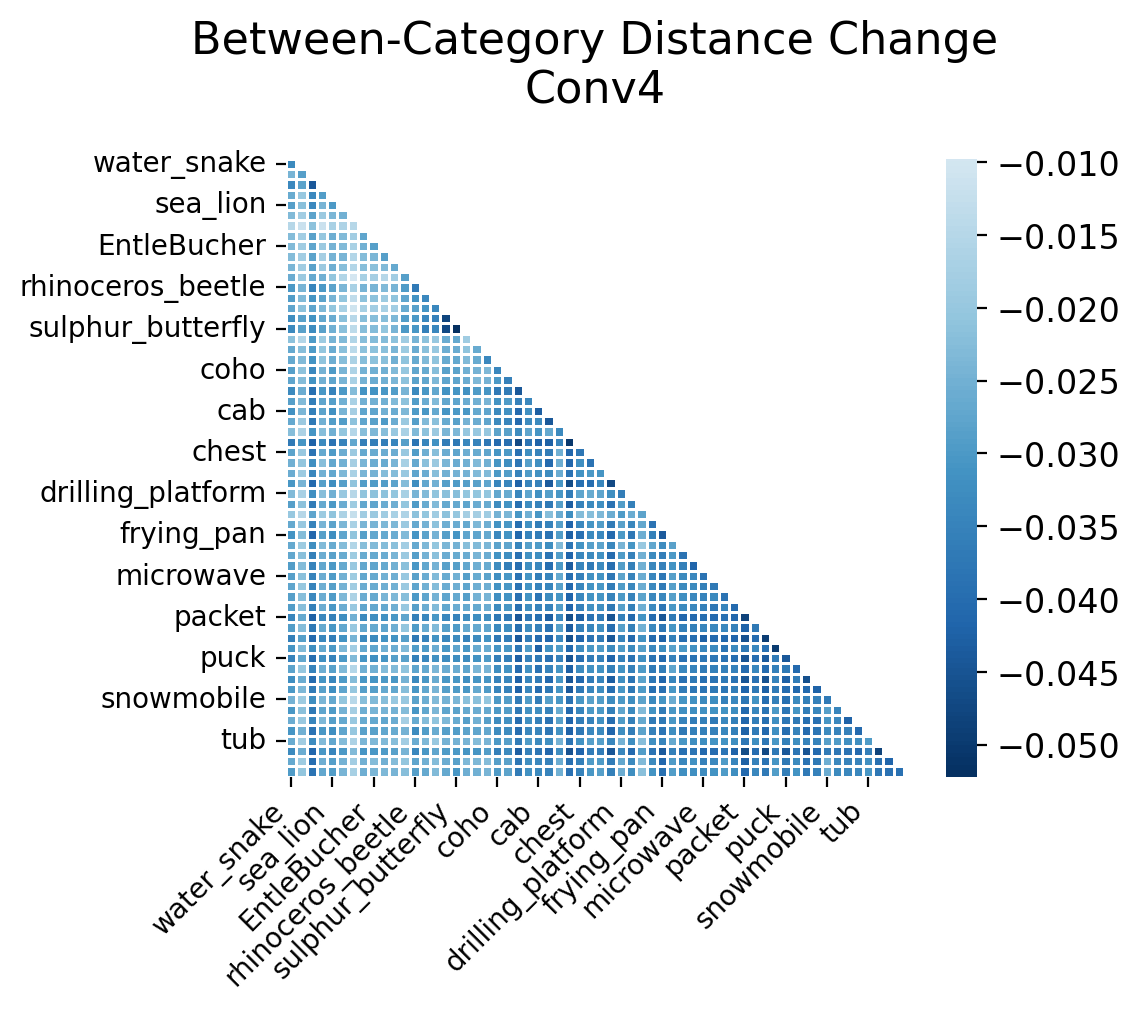

[feedforward_features_9]  avg shift=0.0212,  avg sep=0.1792,  Δsep=-0.0026
[feedforward_features_9]  RSA ρ=0.970, p=0


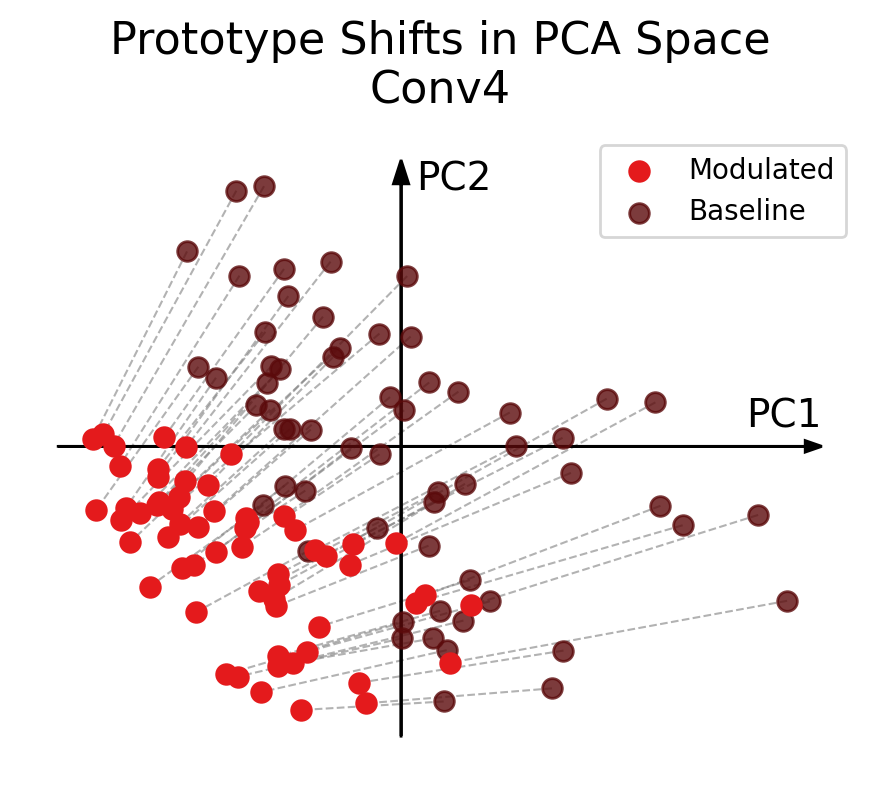

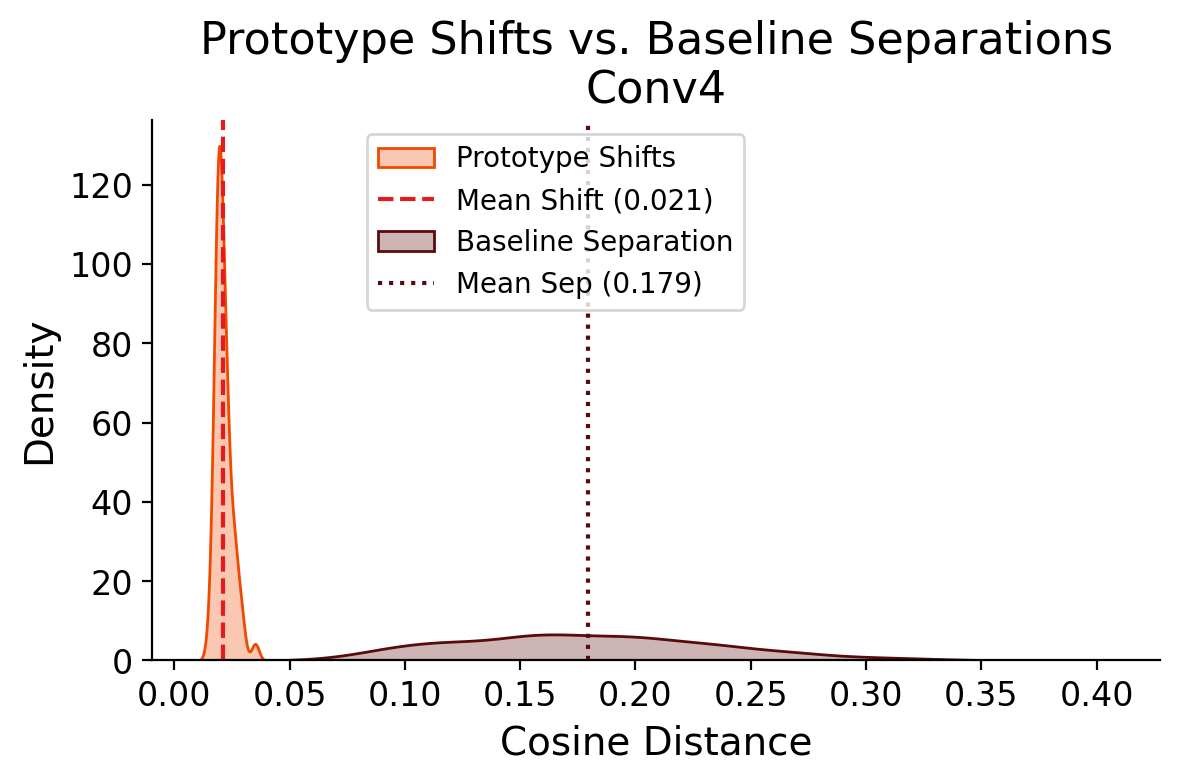

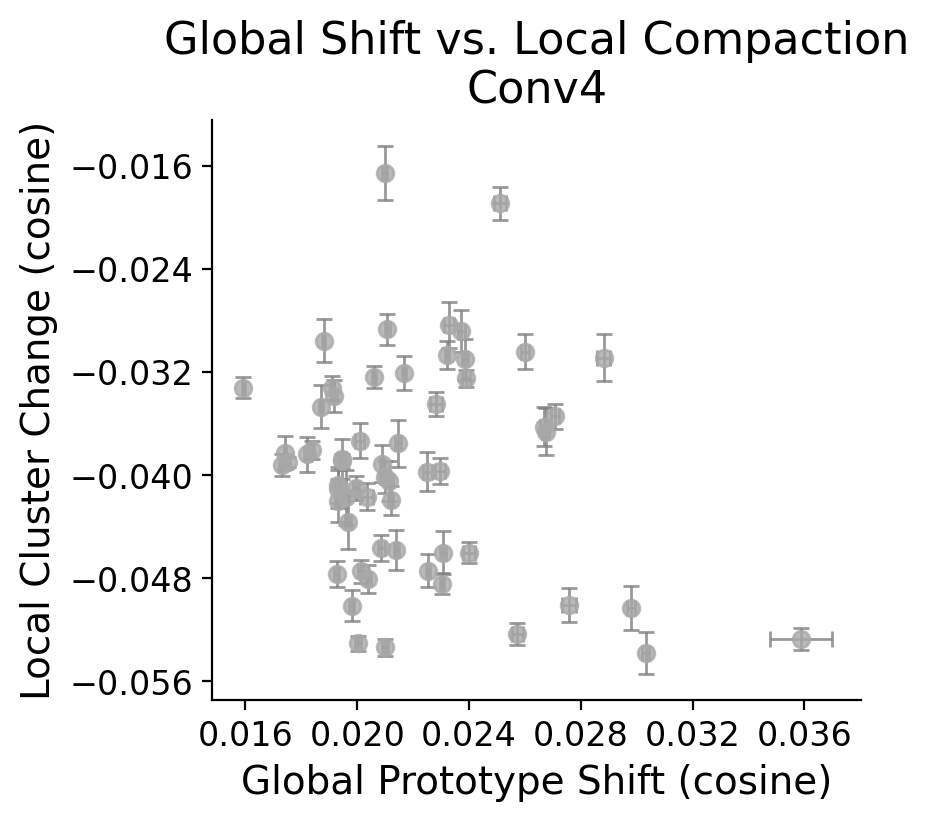


✅ ALL LAYERS DONE


In [6]:
import glob

# ─── CONFIG ────────────────────────────────────────────────────────────────────
OUT_DIR    = "reprGeo_output"
FIG_DIR    = "reprGeo_default/figures/supplements/"
NUM_CATE   = 60
IMG_PER    = 100
LABELS_F    = f"labels_multilayers_imagenettrain_{NUM_CATE}*{IMG_PER}.pt"
KS          = range(2,101)
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load your labels once
labels = torch.load(os.path.join(OUT_DIR, LABELS_F), map_location="cpu")
unique_labels = labels.unique().tolist()

# find every “pass1” activation file
for path1 in sorted(glob.glob(os.path.join(OUT_DIR,
                        f"activations_*_pass1_{NUM_CATE}*{IMG_PER}.pt"))):
    # derive layer key
    basename = os.path.basename(path1)
    layer_key = basename.split("_pass1_")[0].replace("activations_","")
    path3     = path1.replace("_pass1_","_pass3_")

    print(f"\n\n\n\n=== PROCESSING LAYER: {layer_key} ===")
    acts1 = torch.load(path1, map_location=DEVICE)
    acts3 = torch.load(path3, map_location=DEVICE)

    # 1) exemplar→prototype distances
    prot1 = compute_prototypes(acts1, labels, unique_labels)
    prot3 = compute_prototypes(acts3, labels, unique_labels)
    d1    = compute_exemplar_distances(acts1, prot1, labels, unique_labels, "cosine")
    d3    = compute_exemplar_distances(acts3, prot3, labels, unique_labels, "cosine")

    plot_distance_change_histogram(
        distances_baseline=d1,
        distances_modulated=d3,
        category_labels=labels,
        dist_metric_name="cosine",
        save_path=FIG_DIR,
        layer_name=layer_key,
        show_layer_name=True
    )

    # 2) kNN‐based local category preservation
    sim1 = get_cosine_sim_mtx(acts1, DEVICE)
    sim3 = get_cosine_sim_mtx(acts3, DEVICE)
    recall, cat_pres   = get_recall_and_shared_cat_preserve(sim1, sim3, labels, DEVICE, return_cate=True, ks=KS)
    cat_pres_1         = get_category_preservation(sim1, labels, imagesPerCate)
    cat_pres_3         = get_category_preservation(sim3, labels, imagesPerCate)

    plot_category_preservation_curve(
        KS, cat_pres_1, cat_pres_3,
        save_path=FIG_DIR,
        layer_name=layer_key,
        show_layer_name=True
    )

    # 3) between‐category distance change heatmap
    mat = get_cate_distance_change_matrix(sim1, sim3, labels, unique_labels)
    plot_category_distance_change_heatmap(
        matrix=mat,
        unique_labels=unique_labels,
        number2label=number2label,  
        tick_spacing=4,
        cmap='RdBu_r',
        vmin=None, vmax=None,
        save_path=FIG_DIR,
        layer_name=layer_key,
        show_layer_name=True
    )

    # 4) prototype‐shift metrics + RSA
    shifts = compute_prototype_shifts(prot1, prot3)
    sep_base, sep_delta = compute_between_prototype_changes(prot1, prot3)
    rho, pval = calculate_rsa_torch(prot1, prot3)

    print(f"[{layer_key}]  avg shift={shifts.mean().item():.4f},  avg sep={sep_base.mean().item():.4f},  Δsep={sep_delta.mean().item():.4f}")
    print(f"[{layer_key}]  RSA ρ={rho:.3f}, p={pval:.2g}")

    # 5) PCA‐plot + KDE
    plot_prototype_shift_pca(
        prot1, prot3, acts1, acts3,
        pca_on='baseline',
        save_path=FIG_DIR,
        layer_name=layer_key,
        show_layer_name=True
    )
    plot_shift_vs_separation_kde(
        shifts.cpu().numpy(),
        sep_base.cpu().numpy(),
        colors=DEFAULT_COLORS,
        save_path=FIG_DIR,
        layer_name=layer_key,
        show_layer_name=True
    )

    # 6) cross‐val local vs global
    loc_avg, glo_avg, loc_all, glo_all = cross_validation_analysis(
        acts1, 
        acts3, 
        labels=labels, 
        unique_labels=unique_labels, 
        k=5, distance_metric="cosine"
    )
    plot_local_global_correlation(
        global_avg=glo_avg,
        local_avg=loc_avg,
        global_all=glo_all,
        local_all=loc_all,
        error_type='sem',
        annotate=False,
        save_path=FIG_DIR,
        layer_name=layer_key,
        show_layer_name=True
    )

print("\n✅ ALL LAYERS DONE")

# Vanilla AlexNet

## Obtain Activations

In [21]:
from torchvision import transforms
from torchvision.models import alexnet, AlexNet_Weights

dataset_path = f'/teamspace/studios/this_studio/imageData/100*300_imageNet_train_random'

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std =[0.229, 0.224, 0.225]
    )
])
val_loader = create_dataLoader(dataset_path, val_transform, idx2number, shuffle=False, batch_size=100, num_workers=4)

In [24]:
# ─── 1) set up your “vanilla” AlexNet ─────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vanilla_alexnet = alexnet(weights=AlexNet_Weights.DEFAULT)
vanilla_alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [56]:
# 2) define a simple extractor for the output logits
def extract_output_logits(model, loader, device):
    all_logits = []
    with torch.no_grad():
        for imgs,_ in loader:
            imgs = imgs.to(device)
            logits = model(imgs)          # [B x 1000]
            all_logits.append(logits.cpu())
    return torch.cat(all_logits, dim=0)  # [N x 1000]

# 3) run it
acts_vanilla = extract_output_logits(vanilla_alexnet, val_loader, device)
print("output-layer shape:", acts_vanilla.shape)  # should be [N,1000]

# 2) get predictions by taking the argmax of the logits
preds = acts_vanilla.argmax(dim=1)

output-layer shape: torch.Size([30000, 1000])


In [57]:
acc = (preds == labels_1).float().mean().item() * 100.0
print(f"Vanilla AlexNet (classifier.6) top-1 accuracy = {acc:.2f}%")

Vanilla AlexNet (classifier.6) top-1 accuracy = 64.58%


In [58]:
torch.save(acts_vanilla, f'reprGeo_output/vanilla_alexnet_activations_imagenettrain_100*300.pt')

In [5]:
acts_vanilla = torch.load('reprGeo_output/vanilla_alexnet_activations_imagenettrain_100*300.pt')

## Compute Prototypes and Examplar Distances

In [6]:
# prototypes:
unique_labels = torch.unique(labels_1).tolist()
prot1 = compute_prototypes(activations_1, labels_1, unique_labels)
prot3 = compute_prototypes(activations_3, labels_1, unique_labels)
protV = compute_prototypes(acts_vanilla, labels_1, unique_labels)

In [7]:
# exemplar→prototype distances
d1 = compute_exemplar_distances(activations_1, prot1, labels_1, unique_labels, "cosine")
d3 = compute_exemplar_distances(activations_3, prot3, labels_1, unique_labels, "cosine")
dV = compute_exemplar_distances(acts_vanilla, protV, labels_1, unique_labels, "cosine")

In [11]:
def plot_distance_threeway_histogram(
    d_vanilla, d_base, d_mod,
    dist_metric_name="cosine",
    save_path=None, layer_name=""
):
    plt.figure(figsize=(4.5,4))
    # choose three colors
    plt.hist(d_vanilla, bins=30, alpha=0.4, density=True, label="AlexNet", color=DEFAULT_COLORS['vanilla'])
    plt.hist(d_base,    bins=30, alpha=0.4, density=True, label="LRM3 Baseline", color=DEFAULT_COLORS['base'])
    plt.hist(d_mod,     bins=30, alpha=0.4, density=True, label="LRM3 Modulated", color=DEFAULT_COLORS['mod'])
    plt.xlabel(f"Ex.-Proto Distance ({dist_metric_name})")
    plt.title("Cluster‐Size Distributions")
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}{layer_name}_3way_hist.pdf", bbox_inches='tight')
    plt.show()

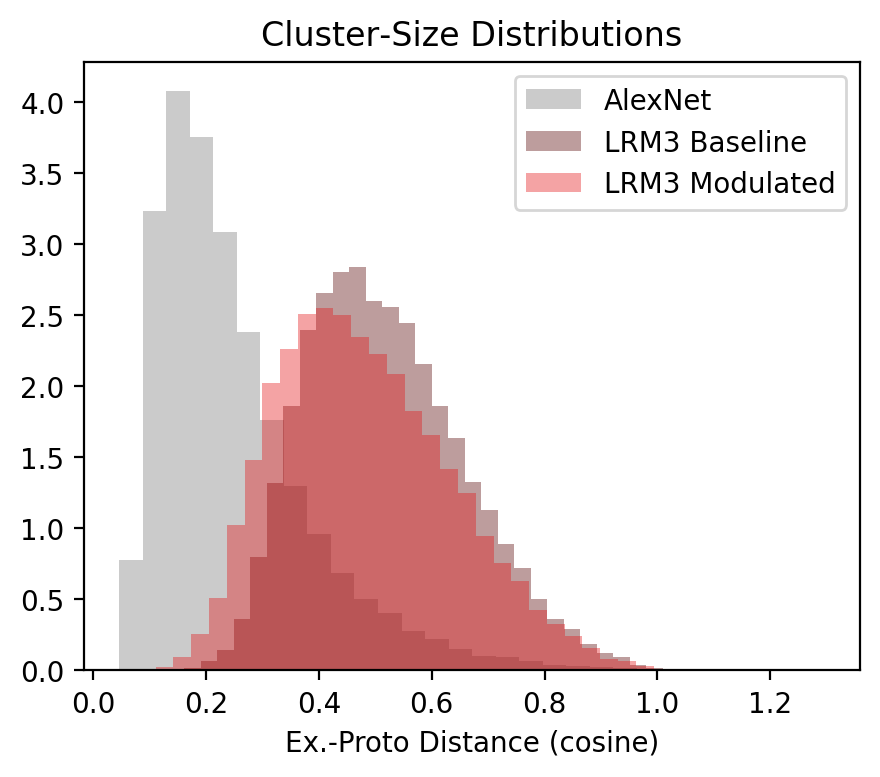

In [13]:
plot_distance_threeway_histogram(
  dV, d1, d3,
  save_path=None,
  layer_name='output'
)

## Compute Category Preservation

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sim1 = get_cosine_sim_mtx(activations_1, DEVICE)
sim3 = get_cosine_sim_mtx(activations_3, DEVICE)
simv = get_cosine_sim_mtx(acts_vanilla, DEVICE)
cp1 = get_category_preservation(sim1, labels_1, 300)
cp3 = get_category_preservation(sim3, labels_1, 300)
cpV = get_category_preservation(simv, labels_1, 300)

In [15]:
def plot_category_preservation_threeway(ks, cp_v, cp_b, cp_m, save_path=None, layer_name=""):
    plt.figure(figsize=(4.5,4))
    plt.plot(ks, cp_v, '-.', label="AlexNet", color=DEFAULT_COLORS['vanilla']) # color="#4C78A8"
    plt.plot(ks, cp_b, '--',label="LRM3 Base", color=DEFAULT_COLORS['base']) # color="#E45756"
    plt.plot(ks, cp_m, '-',label="LRM3 Mod", color=DEFAULT_COLORS['mod']) # color="#72B7B2"
    plt.xlabel("k")
    plt.ylabel("Prop same‐cat")
    plt.title("Local Category Preservation")
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}{layer_name}_3way_knn.pdf",bbox_inches='tight')
    plt.show()

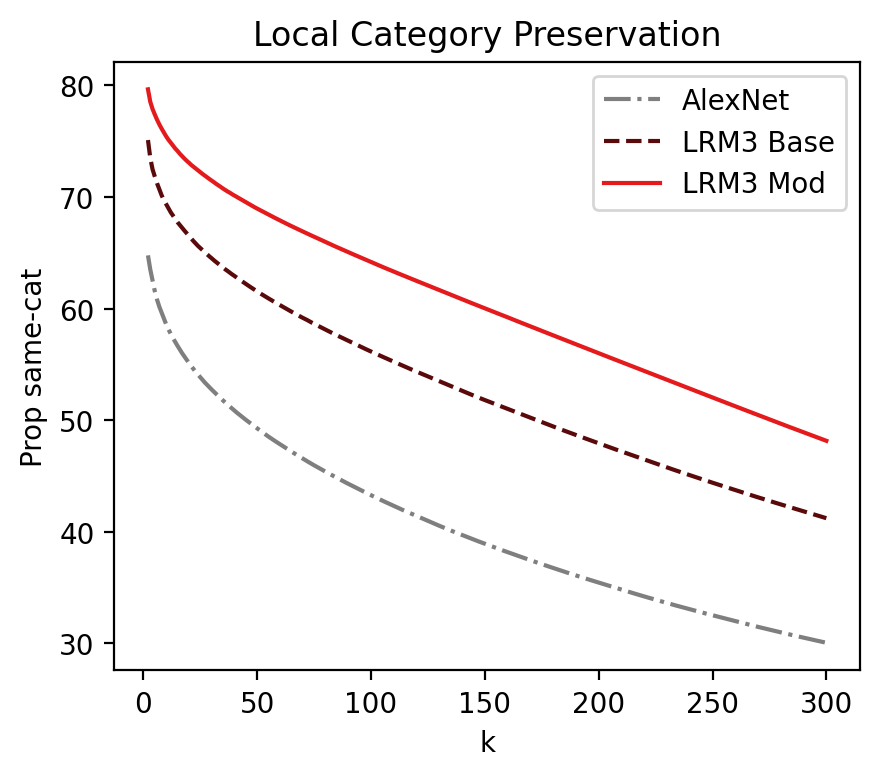

In [16]:
plot_category_preservation_threeway(
  range(2,301), cpV, cp1, cp3,
  save_path=None,
  layer_name='output'
)

## Calculate between prototype distances

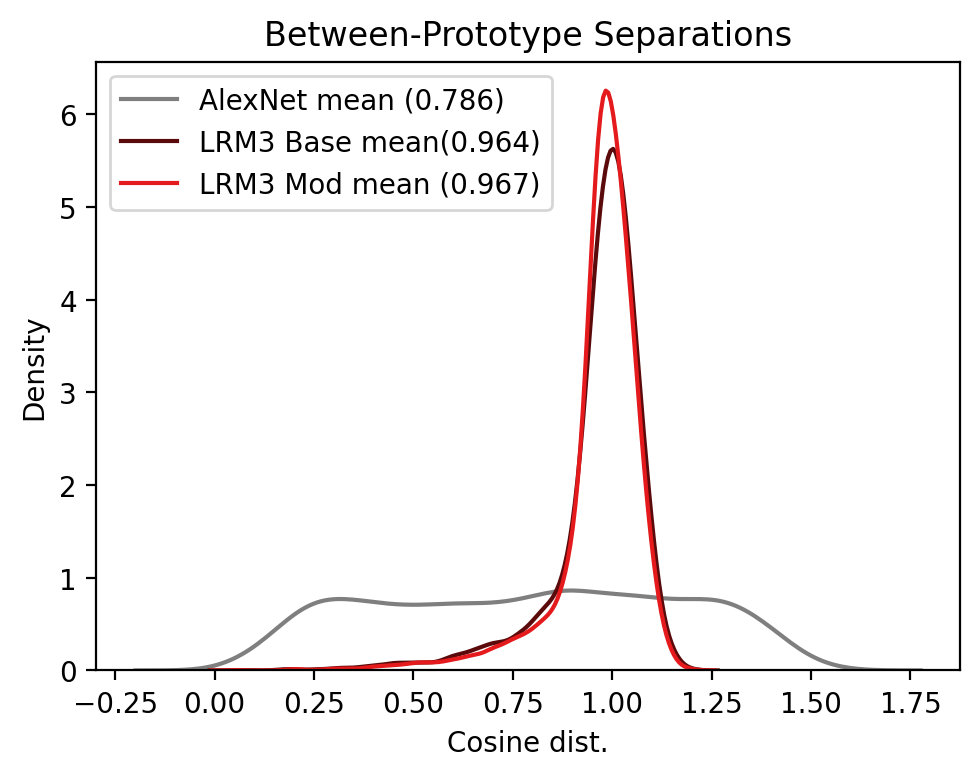

In [ ]:
## Calculate between prototype distances
# compute RDM‐vectors
def get_rdm_vec(prots):
    sim = F.cosine_similarity(prots.unsqueeze(1), prots.unsqueeze(0), dim=-1)
    dist = 1 - sim
    idx  = torch.triu_indices(len(prots),len(prots),offset=1)
    return dist[idx[0],idx[1]].cpu().numpy()

rV = get_rdm_vec(protV)
r1 = get_rdm_vec(prot1)
r3 = get_rdm_vec(prot3)

plt.figure(figsize=(5,4))
sns.kdeplot(rV, label=f"AlexNet mean ({rV.mean():.3f})", color=DEFAULT_COLORS['vanilla'])
sns.kdeplot(r1, label=f"LRM3 Base mean({r1.mean():.3f})", color=DEFAULT_COLORS['base'])
sns.kdeplot(r3, label=f"LRM3 Mod mean ({r3.mean():.3f})",  color=DEFAULT_COLORS['mod'])
plt.xlabel("Cosine dist.")
plt.ylabel("Density")
plt.title("Between-Prototype Separations")
plt.legend()
plt.tight_layout()
# plt.savefig(f"{FIG_DIR}{layer_key}_3way_sep_kde.pdf",bbox_inches='tight')
plt.show()

# Dimension Reduction

In [6]:
# --- 1) PCA per‐category only ---
def compute_category_pcs(
    activations: torch.Tensor,
    labels:      torch.Tensor,
    var_threshold: float = 0.90
):
    """
    For each category in labels, runs PCA on its exemplars
    and returns:
      pcs_needed: list[int]  — # PCs to explain var_threshold
      stats:      dict[int,dict] with {'n_pc'} per category
    """
    cats = torch.unique(labels).tolist()
    pcs_needed = []
    stats = {}

    for c in cats:
        idx = (labels == c).nonzero(as_tuple=True)[0]
        X = activations[idx].cpu().numpy()
        pca = PCA().fit(X)
        cumvar = np.cumsum(pca.explained_variance_ratio_)
        n_pc = int(np.searchsorted(cumvar, var_threshold)) + 1
        pcs_needed.append(n_pc)
        stats[c] = {'n_pc': n_pc}

    return stats, pcs_needed

In [ ]:
# --- 2) Procrustes per‐category ---
def compute_category_procrustes(
    activations_base: torch.Tensor,
    activations_mod:  torch.Tensor,
    labels:           torch.Tensor
):
    """
    For each category in labels, runs a Procrustes alignment
    between its baseline and modulated exemplar clouds,
    returns:
      disparities: list[float]  — Procrustes disparity per category
      stats:       dict[int,dict] with {'disparity'} per category
    """
    cats = torch.unique(labels).tolist()
    disparities = []
    stats = {}

    for c in cats:
        idx = (labels == c).nonzero(as_tuple=True)[0]
        A = activations_base[idx].cpu().numpy()
        B = activations_mod[idx].cpu().numpy()
        _, _, disp = procrustes(A, B)
        disparities.append(disp)
        stats[c] = {'disparity': float(disp)}

    return stats, disparities

In [37]:
# --- 3) Threshold sweep driver & plotting ---
def sweep_variance_thresholds(
    acts_base: torch.Tensor,
    acts_mod:  torch.Tensor,
    labels:    torch.Tensor,
    thresholds: list[float]
):
    """
    For each var_threshold in thresholds, compute:
      mean_npc_base, mean_npc_mod, mean_delta = mean_npc_mod - mean_npc_base
    Returns four lists, all length=len(thresholds).
    """
    mean_base, mean_mod, mean_delta = [], [], []
    for thr in thresholds:
        _, pcsA = compute_category_pcs(acts_base, labels, var_threshold=thr)
        _, pcsB = compute_category_pcs(acts_mod,  labels, var_threshold=thr)
        arrA, arrB = np.array(pcsA), np.array(pcsB)
        mean_base.append(arrA.mean())
        mean_mod .append(arrB.mean())
        mean_delta.append((arrB - arrA).mean())
    return mean_base, mean_mod, mean_delta
    
def plot_sweep_pcs(
    thresholds, mean_base, mean_mod,
    save_path: str = None
):
    plt.figure(figsize=(5,4))
    plt.plot(thresholds, mean_base, marker='o', label='Baseline', color=DEFAULT_COLORS['base'])
    plt.plot(thresholds, mean_mod,  marker='o', label='Modulated', color=DEFAULT_COLORS['mod'])
    plt.xlabel("Variance Threshold")
    plt.ylabel("Mean # PCs")
    plt.title("PCA Dimensionality vs Variance Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_path: plt.savefig(save_path.replace(".pdf","_pcs.pdf"))
    plt.show()

def plot_sweep_delta(
    thresholds, mean_delta,
    save_path: str = None
):
    plt.figure(figsize=(5,4))
    plt.plot(thresholds, mean_delta, marker='o', color='gray')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Variance Threshold")
    plt.ylabel("Mean Δ#PC (mod-base)")
    plt.title("Change in Dimensionality vs Threshold")
    plt.grid(True)
    plt.tight_layout()
    if save_path: plt.savefig(save_path.replace(".pdf","_delta.pdf"))
    plt.show()

In [ ]:
thresholds = np.linspace(0.3,0.99,12)
mean_base, mean_mod, mean_delta = sweep_variance_thresholds(activations_1, activations_3, labels_1, thresholds)

plot_sweep_pcs(
    thresholds, mean_base, mean_mod, 
    save_path=None
)
plot_sweep_delta(
    thresholds, mean_delta,
    save_path=None
)

In [19]:
torch.save(
    {
      "thresholds": thresholds,
      "mean_base": mean_base,
      "mean_mod": mean_mod,
      "mean_delta": mean_delta
    },
    "reprGeo_output/dimention_reduction_pca_threshold_sweep_results_100*300.pt"
)

In [38]:
dim_reduc_res = torch.load("reprGeo_output/dimention_reduction_pca_threshold_sweep_results_100*300.pt")
thresholds, mean_base, mean_mod, mean_delta = dim_reduc_res["thresholds"], dim_reduc_res["mean_base"], dim_reduc_res["mean_mod"], dim_reduc_res["mean_delta"]

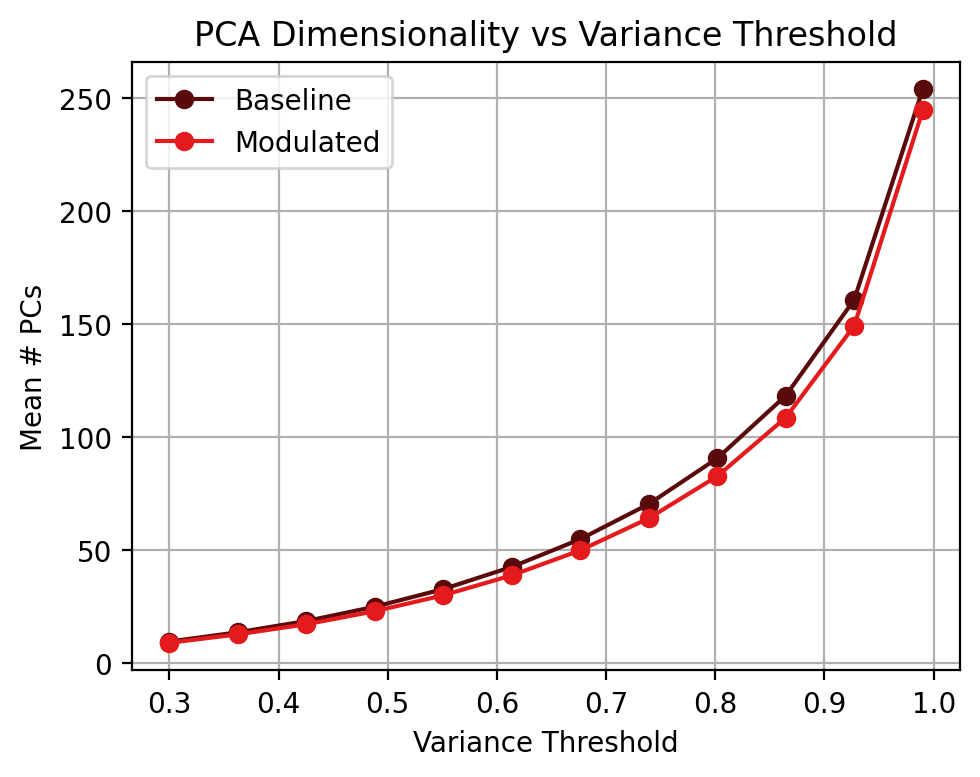

In [39]:
plot_sweep_pcs(
    thresholds, mean_base, mean_mod, 
    save_path=None
)

In [8]:
# --- 4) Example usage in your notebook ---
_, pcsA = compute_category_pcs(activations_1, labels_1, var_threshold=0.90)
_, pcsB = compute_category_pcs(activations_3, labels_1, var_threshold=0.90)

In [ ]:
statsP, disps = compute_category_procrustes(activations_1, activations_3, labels_1)

In [35]:
def plot_pc_histograms(
    pcs_before: list,
    pcs_after:  list,
    title:     str = "PCs Required (90% var)",
    bins:      int = 30,
    save_path: str = None
):
    """
    Overlayed histogram of PCs before vs. after.
    """
    plt.figure(figsize=(5,4))
    plt.hist(pcs_before, bins=bins, alpha=0.6, label='Baseline', color=DEFAULT_COLORS['base'])
    plt.hist(pcs_after,  bins=bins, alpha=0.6, label='Modulated', color=DEFAULT_COLORS['mod'])
    plt.xlabel("# PCs")
    plt.ylabel("Count of Categories")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def plot_disparity_histogram(
    disparities: list,
    bins:        int = 30,
    title:       str = "Procrustes Disparities",
    save_path:   str = None
):
    """
    Histogram of the Procrustes disparity per category.
    """
    plt.figure(figsize=(5,4))
    plt.hist(disparities, bins=bins, color='gray', edgecolor='black', alpha=0.7)
    plt.xlabel("Disparity")
    plt.ylabel("Count of Categories")
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [ ]:
# overlayed #PC histogram
plot_pc_histograms(
    pcs_before=pcsA,
    pcs_after =pcsB,
    # save_path='reprGeo_default/figures/pc_counts_hist.pdf'
)

# disparity histogram
plot_disparity_histogram(
    disparities=disps,
    # save_path='reprGeo_default/figures/disparity_hist.pdf'
)

## Vanilla AlexNet Dimension 

In [ ]:
_, pcs_1 = compute_category_pcs(activations_1, labels_1, var_threshold=0.90)
_, pcs_3 = compute_category_pcs(activations_3, labels_1, var_threshold=0.90)
_, pcs_v = compute_category_pcs(acts_vanilla, labels_1, var_threshold=0.90)

In [29]:
def plot_three_pc_histograms(
    pcs_vanilla:  list,
    pcs_baseline: list,
    pcs_modulated:list,
    title:        str = "PCs Required (90% var)",
    bins:         int = 30,
    save_path:    str = None
):
    """
    Overlayed histogram of #PCs for Vanilla AlexNet, LRM3 baseline and
    LRM3 modulated activations.
    """
    plt.figure(figsize=(5,4))
    plt.hist(pcs_vanilla,  bins=bins, alpha=0.6, label='Vanilla',   color=DEFAULT_COLORS['vanilla'])
    plt.hist(pcs_baseline, bins=bins, alpha=0.6, label='Baseline',  color=DEFAULT_COLORS['base'])
    plt.hist(pcs_modulated,bins=bins, alpha=0.6, label='Modulated', color=DEFAULT_COLORS['mod'])
    plt.xlabel("# PCs to reach threshold")
    plt.ylabel("Count of categories")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

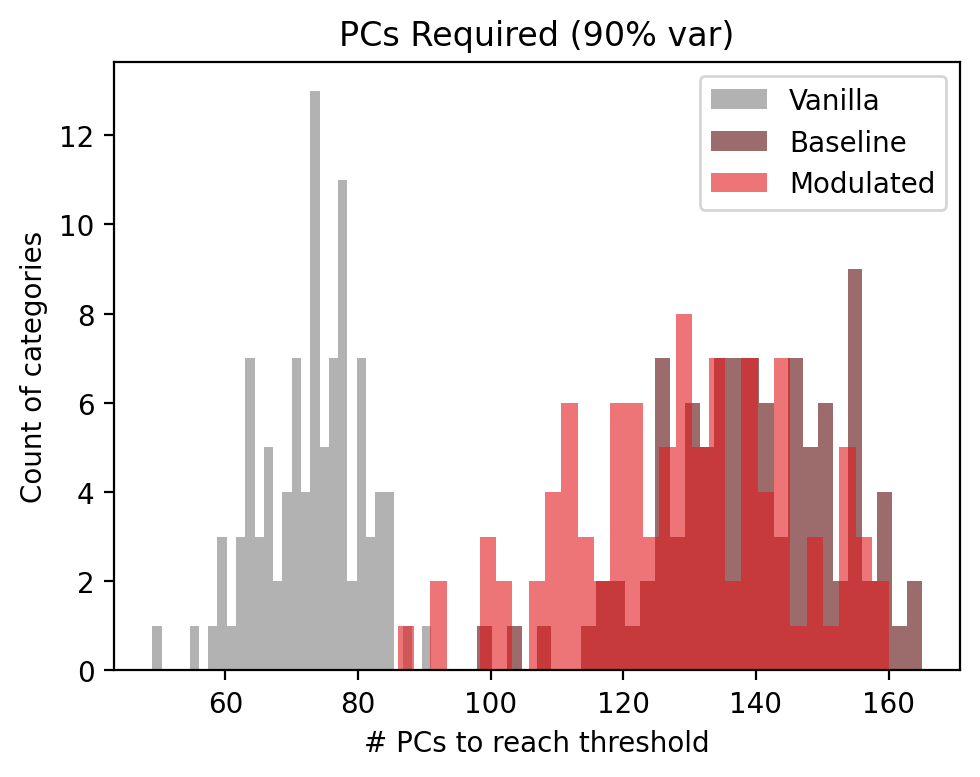

In [30]:
plot_three_pc_histograms(pcs_v, pcs_1, pcs_3)

In [33]:
def sweep_three_pcs(acts0, acts1, acts3, labels, thresholds):
    mean0, mean1, mean3 = [], [], []
    for t in thresholds:
        _, p0 = compute_category_pcs(acts0, labels, var_threshold=t)
        _, p1 = compute_category_pcs(acts1, labels, var_threshold=t)
        _, p3 = compute_category_pcs(acts3, labels, var_threshold=t)
        mean0.append(np.mean(p0))
        mean1.append(np.mean(p1))
        mean3.append(np.mean(p3))
    return mean0, mean1, mean3

def plot_sweep_three(
    thresholds, mean0, mean1, mean3,
    labels=('Vanilla','Baseline','Modulated'),
    save_path=None
):
    plt.figure(figsize=(5,4))
    plt.plot(thresholds, mean0, marker='o', label=labels[0], color=DEFAULT_COLORS['vanilla'])
    plt.plot(thresholds, mean1, marker='s', label=labels[1], color=DEFAULT_COLORS['base'])
    plt.plot(thresholds, mean3, marker='^', label=labels[2], color=DEFAULT_COLORS['mod'])
    plt.xlabel("Variance Threshold")
    plt.ylabel("Mean # PCs")
    plt.title("Dims vs Threshold")
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [ ]:
ths = np.linspace(0.3, 0.99, 12)
m0, m1, m3 = sweep_three_pcs(acts_vanilla, activations_1, activations_3, labels_1, ths)

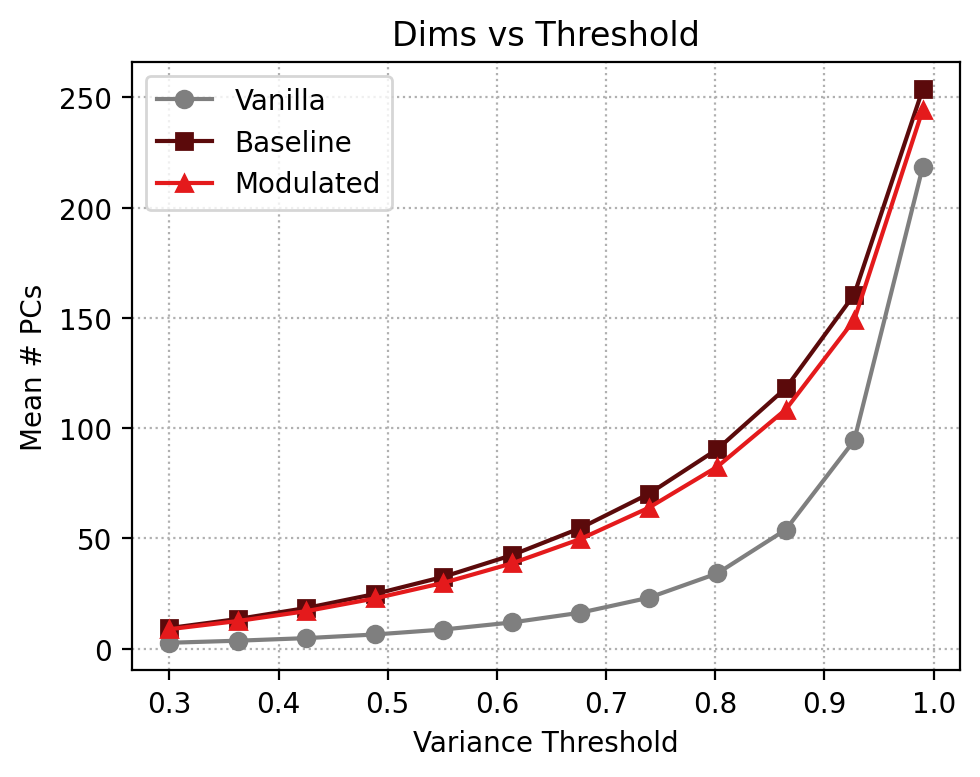

In [34]:
plot_sweep_three(ths, m0, m1, m3,
    save_path=None)